# Assignment 2

## Abstract

This notebook presents the construction and interpretation of an AutoML-based predictive model for Valorant player ratings. Key steps include environment setup, H2O server initialization, and data preparation, where multicollinear features are pruned to improve model reliability. The model, with a focus on the Gradient Boosting Machine (GBM), undergoes training and performance evaluation through metrics like MSE and RMSE. Results demonstrate the model's strong fit to the data. Insightful Variable Importance Plots further illuminate the predominant factors influencing player ratings.

In [1]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [2]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [3]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split as tts
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [4]:
min_mem_size=6 
run_time=222

In [5]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

1


In [6]:
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:38609..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.10+11-LTS-240, mixed mode, sharing)
  Starting server from C:\Users\pende\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\pende\AppData\Local\Temp\tmpo9f73pfk
  JVM stdout: C:\Users\pende\AppData\Local\Temp\tmpo9f73pfk\h2o_pende_started_from_python.out
  JVM stderr: C:\Users\pende\AppData\Local\Temp\tmpo9f73pfk\h2o_pende_started_from_python.err
  Server is running at http://127.0.0.1:38609
Connecting to H2O server at http://127.0.0.1:38609 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_pende_rwnkct
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.979 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [7]:
#importing the dataset to this notebook
data = pd.read_csv("https://raw.githubusercontent.com/MukulSaiPendem/DSEM_Assignment_2/main/val_stats.csv", low_memory=False)

## DATASET DESCRIPTION
This dataset contains data related to player performance in a competitive video game Valorant. This is a first person shooter video game. 

In [8]:
data.columns

Index(['region', 'name', 'tag', 'rating', 'damage_round', 'headshots',
       'headshot_percent', 'aces', 'clutches', 'flawless', 'first_bloods',
       'kills', 'deaths', 'assists', 'kd_ratio', 'kills_round', 'most_kills',
       'score_round', 'wins', 'win_percent', 'agent_1', 'agent_2', 'agent_3',
       'gun1_name', 'gun1_head', 'gun1_body', 'gun1_legs', 'gun1_kills',
       'gun2_name', 'gun2_head', 'gun2_body', 'gun2_legs', 'gun2_kills',
       'gun3_name', 'gun3_head', 'gun3_body', 'gun3_legs', 'gun3_kills'],
      dtype='object')

## Variable Descriptions

**Region**: 
<span style="color:green;">Indicates the geographical location or server region of the player. Different regions can represent different player communities and competitive environments.</span>

**Name**: 
<span style="color:green;">The in-game username chosen by the player. It's a unique identifier for each player within the game.</span>

**Tag**: 
<span style="color:green;">An additional identifier or code associated with the player's account, often used in conjunction with the name for unique identification.</span>

**Rating**: 
<span style="color:green;">A numerical value representing the player's skill level or rank. Higher ratings usually indicate more skilled or experienced players.</span>

**Damage per Round**: 
<span style="color:green;">Shows the average amount of damage the player inflicts on opponents in each round. This is a measure of the player's effectiveness in harming opponents, with higher values indicating greater impact in the game.</span>

**Headshots**: 
<span style="color:green;">The total number of times a player has successfully hit opponents in the head. Headshots are typically more difficult to achieve but are more effective in the game.</span>

**Headshot Percent**: 
<span style="color:green;">The percentage of the player's shots that result in headshots. A higher percentage is indicative of better precision and aiming skill.</span>

**Kills**: 
<span style="color:green;">The total number of opponents a player has eliminated. This is a direct measure of offensive performance.</span>

**Deaths**: 
<span style="color:green;">The number of times a player has been eliminated by an opponent. This figure is used to assess a player's survivability and defensive skills.</span>

**Assists**: 
<span style="color:green;">The count of assists represents the number of times a player has helped a teammate kill an opponent. Assists can indicate a player's teamwork and support capabilities.</span>

**K/D Ratio**: 
<span style="color:green;">The kill/death ratio is calculated by dividing the number of kills by the number of deaths. A higher ratio suggests that a player eliminates more opponents than they are eliminated.</span>

**Kills per Round**: 
<span style="color:green;">The average number of kills a player achieves each round, which shows their consistent contribution to the team's offensive efforts.</span>

**Most Kills**: 
<span style="color:green;">The highest number of kills a player has achieved in a single game. This can highlight a player's peak performance capability.</span>

**Score per Round**: 
<span style="color:green;">The average score a player achieves per round, factoring in various aspects of their performance, not just eliminations.</span>

**Wins**: 
<span style="color:green;">The number of games a player or their team has won. Wins are the ultimate objective and indicate the effectiveness of a player's contribution to the team's success.</span>

**Win Percent**: 
<span style="color:green;">The percentage of games won out of all games played. This metric is used to gauge overall team success and, indirectly, the player's impact on games.</span>

**Aces**: 
<span style="color:green;">Counts the number of times a player has single-handedly eliminated all opposing team members in a round. This is a rare and notable achievement, showcasing exceptional individual skill.</span>

**Clutches**: 
<span style="color:green;">The number of rounds a player wins single-handedly while being the last surviving member of their team against multiple opponents. This metric highlights the player's ability to perform under high-pressure situations.</span>

**Flawless**: 
<span style="color:green;">Refers to rounds where the player's team wins without losing any team members. It indicates a round dominated by the player's team.</span>

**Gun Statistics**: 
<span style="color:green;">These include detailed performance metrics for different guns used by players. Each gun has associated statistics like gun name, head, body, legs, and kills, providing insights into weapon proficiency and playstyle.</span>
<span style="color:black;">all theses columns come under this 'gun1_name', 'gun1_head', 'gun1_body', 'gun1_legs', 'gun1_kills', 'gun2_name', 'gun2_head', 'gun2_body', 'gun2_legs', 'gun2_kills', 'gun3_name', 'gun3_head', 'gun3_body', 'gun3_legs', 'gun3_kills'</span>

 ## What are the data types? 

In [9]:
data.dtypes

region               object
name                 object
tag                  object
rating               object
damage_round        float64
headshots            object
headshot_percent      int64
aces                  int64
clutches              int64
flawless              int64
first_bloods          int64
kills                object
deaths               object
assists              object
kd_ratio            float64
kills_round         float64
most_kills            int64
score_round         float64
wins                  int64
win_percent         float64
agent_1              object
agent_2              object
agent_3              object
gun1_name            object
gun1_head             int64
gun1_body             int64
gun1_legs             int64
gun1_kills           object
gun2_name            object
gun2_head             int64
gun2_body             int64
gun2_legs             int64
gun2_kills           object
gun3_name            object
gun3_head             int64
gun3_body           

Some features are wrongly classified as object dtype due to the issue with commas (,) typically arises from the way numbers are formatted in certain locales. In many places, commas are used as thousand separators to improve readability of large numbers. For example, the number one thousand is often written as 1,000.

these columns have this issue
'gun1_kills', 'gun2_kills', 'first_bloods', 'headshots', 'deaths', 'kills', 'assists'

**How to correct this?**
we need to replace the (,) with ''. this is resolve the wrong interpretation.

In [10]:
# Function to safely convert columns to integers
def convert_column_to_int(df, column_name):
    if df[column_name].dtype == 'object':
        df[column_name] = pd.to_numeric(df[column_name].str.replace(',', ''), errors='coerce')
    return df

# Columns that we expect to be numeric but may contain commas
columns_with_potential_commas = ['gun1_kills', 'gun2_kills', 'first_bloods', 'headshots', 'deaths', 'kills', 'assists']

# Apply the conversion to each column
for col in columns_with_potential_commas:
    data = convert_column_to_int(data, col)

# Now check the dtypes to confirm the conversion
data.dtypes

region               object
name                 object
tag                  object
rating               object
damage_round        float64
headshots             int64
headshot_percent      int64
aces                  int64
clutches              int64
flawless              int64
first_bloods          int64
kills                 int64
deaths                int64
assists               int64
kd_ratio            float64
kills_round         float64
most_kills            int64
score_round         float64
wins                  int64
win_percent         float64
agent_1              object
agent_2              object
agent_3              object
gun1_name            object
gun1_head             int64
gun1_body             int64
gun1_legs             int64
gun1_kills            int64
gun2_name            object
gun2_head             int64
gun2_body             int64
gun2_legs             int64
gun2_kills            int64
gun3_name            object
gun3_head             int64
gun3_body           

## Numeric Data Types:

- **Float64**: `damage_round`, `headshot_percent`, `kd_ratio`, `kills_round`, `score_round`, `win_percent`. 
  - These are floating-point numbers and can represent quantities with decimal precision.

- **Int64**: `headshots`, `first_bloods`, `kills`, `deaths`, `assists`, `aces`, `clutches`, `flawless`, `most_kills`, `wins`, `gun1_head`, `gun1_body`, `gun1_legs`, `gun2_head`, `gun2_body`, `gun2_legs`, `gun3_head`, `gun3_body`, `gun3_legs`, `gun3_kills` , `gun1_kills`, `gun2_kills`. 
  - These are integer numbers and represent whole quantities without decimals.

## Categorical Data Types:

- **Object**: `region`, `name`, `tag`, `rating`, `assists`, `agent_1`, `agent_2`, `agent_3`, `gun1_name`, `gun2_name`, `gun3_name`. 
  - These are typically non-numeric data and are treated as categorical.

As the data Size is huge, to reduce high computation time we are going to do **Sampling** on the Dataset

In [11]:
sampled_dataset = data.sample(frac=0.2, random_state=1)

## Are there missing values?

Yes, there are some missing values in the dataset.

In [12]:
sampled_dataset.isnull().sum()

region              4236
name                   0
tag                   71
rating                 0
damage_round           0
headshots              0
headshot_percent       0
aces                   0
clutches               0
flawless               0
first_bloods           0
kills                  0
deaths                 0
assists                0
kd_ratio               0
kills_round            0
most_kills             0
score_round            0
wins                   0
win_percent            0
agent_1                0
agent_2              412
agent_3             1057
gun1_name              0
gun1_head              0
gun1_body              0
gun1_legs              0
gun1_kills             0
gun2_name              0
gun2_head              0
gun2_body              0
gun2_legs              0
gun2_kills             0
gun3_name              0
gun3_head              0
gun3_body              0
gun3_legs              0
gun3_kills             0
dtype: int64

##  Which independent variables have missing data? How much? 

### Missing Values in the Dataset

- `region`: 4225 missing values
- `name`: 0 missing values
- `tag`: 48 missing values
- `agent_2`: 375 missing values
- `agent_3`: 1005 missing values

All other columns do not have missing values. Handling these missing values is a crucial step in the data preprocessing phase prior to any detailed analysis or predictive modeling.
We only have missing values in 5 featues( catagorical ), all numerical feature are complete without any missing values

## How can we remove the missing values?

As our missing values are only from catagorical data, lets use **Mode Imputation**

### Mode Imputation

The method of replacing missing values in each categorical column with the most frequent value (mode) in that column is commonly referred to as "Mode Imputation" or "Imputation by the Most Frequent Value."

In [13]:
# Identifying categorical columns
categorical_columns = sampled_dataset.select_dtypes(include=['object', 'category']).columns

# Applying mode imputation
for col in categorical_columns:
    most_frequent_value = sampled_dataset[col].mode()[0]
    sampled_dataset[col].fillna(most_frequent_value, inplace=True)

# Checking for remaining null values
print("Remaining null values after mode imputation:\n", sampled_dataset.isnull().sum())

Remaining null values after mode imputation:
 region              0
name                0
tag                 0
rating              0
damage_round        0
headshots           0
headshot_percent    0
aces                0
clutches            0
flawless            0
first_bloods        0
kills               0
deaths              0
assists             0
kd_ratio            0
kills_round         0
most_kills          0
score_round         0
wins                0
win_percent         0
agent_1             0
agent_2             0
agent_3             0
gun1_name           0
gun1_head           0
gun1_body           0
gun1_legs           0
gun1_kills          0
gun2_name           0
gun2_head           0
gun2_body           0
gun2_legs           0
gun2_kills          0
gun3_name           0
gun3_head           0
gun3_body           0
gun3_legs           0
gun3_kills          0
dtype: int64


### the most useful Independent Variables can be statistically determined using the following methods:

1. Univariate Selection
2. Feature Importance
3. Correlation Matrix with Heatmap

In [14]:
for column in sampled_dataset.columns:
    if sampled_dataset[column].dtype == 'object':
        sampled_dataset[column] = sampled_dataset[column].astype('category').cat.codes

### Univariate Selection

In [15]:
X = sampled_dataset.drop('rating', axis=1)  # Features
y = sampled_dataset['rating']  #  'rating' is the target variable
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X.select_dtypes(include=['number']), y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  # naming the dataframe columns

univariate_scores = featureScores.nlargest(38, 'Score')
univariate_scores

,Specs,Score
10,kills,1.150357e+06
11,deaths,9.695957e+05
9,first_bloods,8.299393e+05
4,headshots,8.100215e+05
26,gun1_kills,5.558099e+05
12,assists,3.307905e+05
31,gun2_kills,1.619552e+05
2,tag,1.589609e+05
7,clutches,9.623903e+04
36,gun3_kills,7.966026e+04


### Feature Importance with RandomForestClassifier()

In [16]:
# Feature Importance
model = RandomForestClassifier()
model.fit(X, y)
importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance_sorted = feature_importances.sort_values('importance', ascending=False)
feature_importance_sorted

,feature,importance
5,headshot_percent,0.332410
9,first_bloods,0.267804
6,aces,0.241719
4,headshots,0.014103
17,wins,0.012545
26,gun1_kills,0.010300
10,kills,0.009373
18,win_percent,0.008856
7,clutches,0.008234
11,deaths,0.007270


### Correlation Matrix with Heatmap

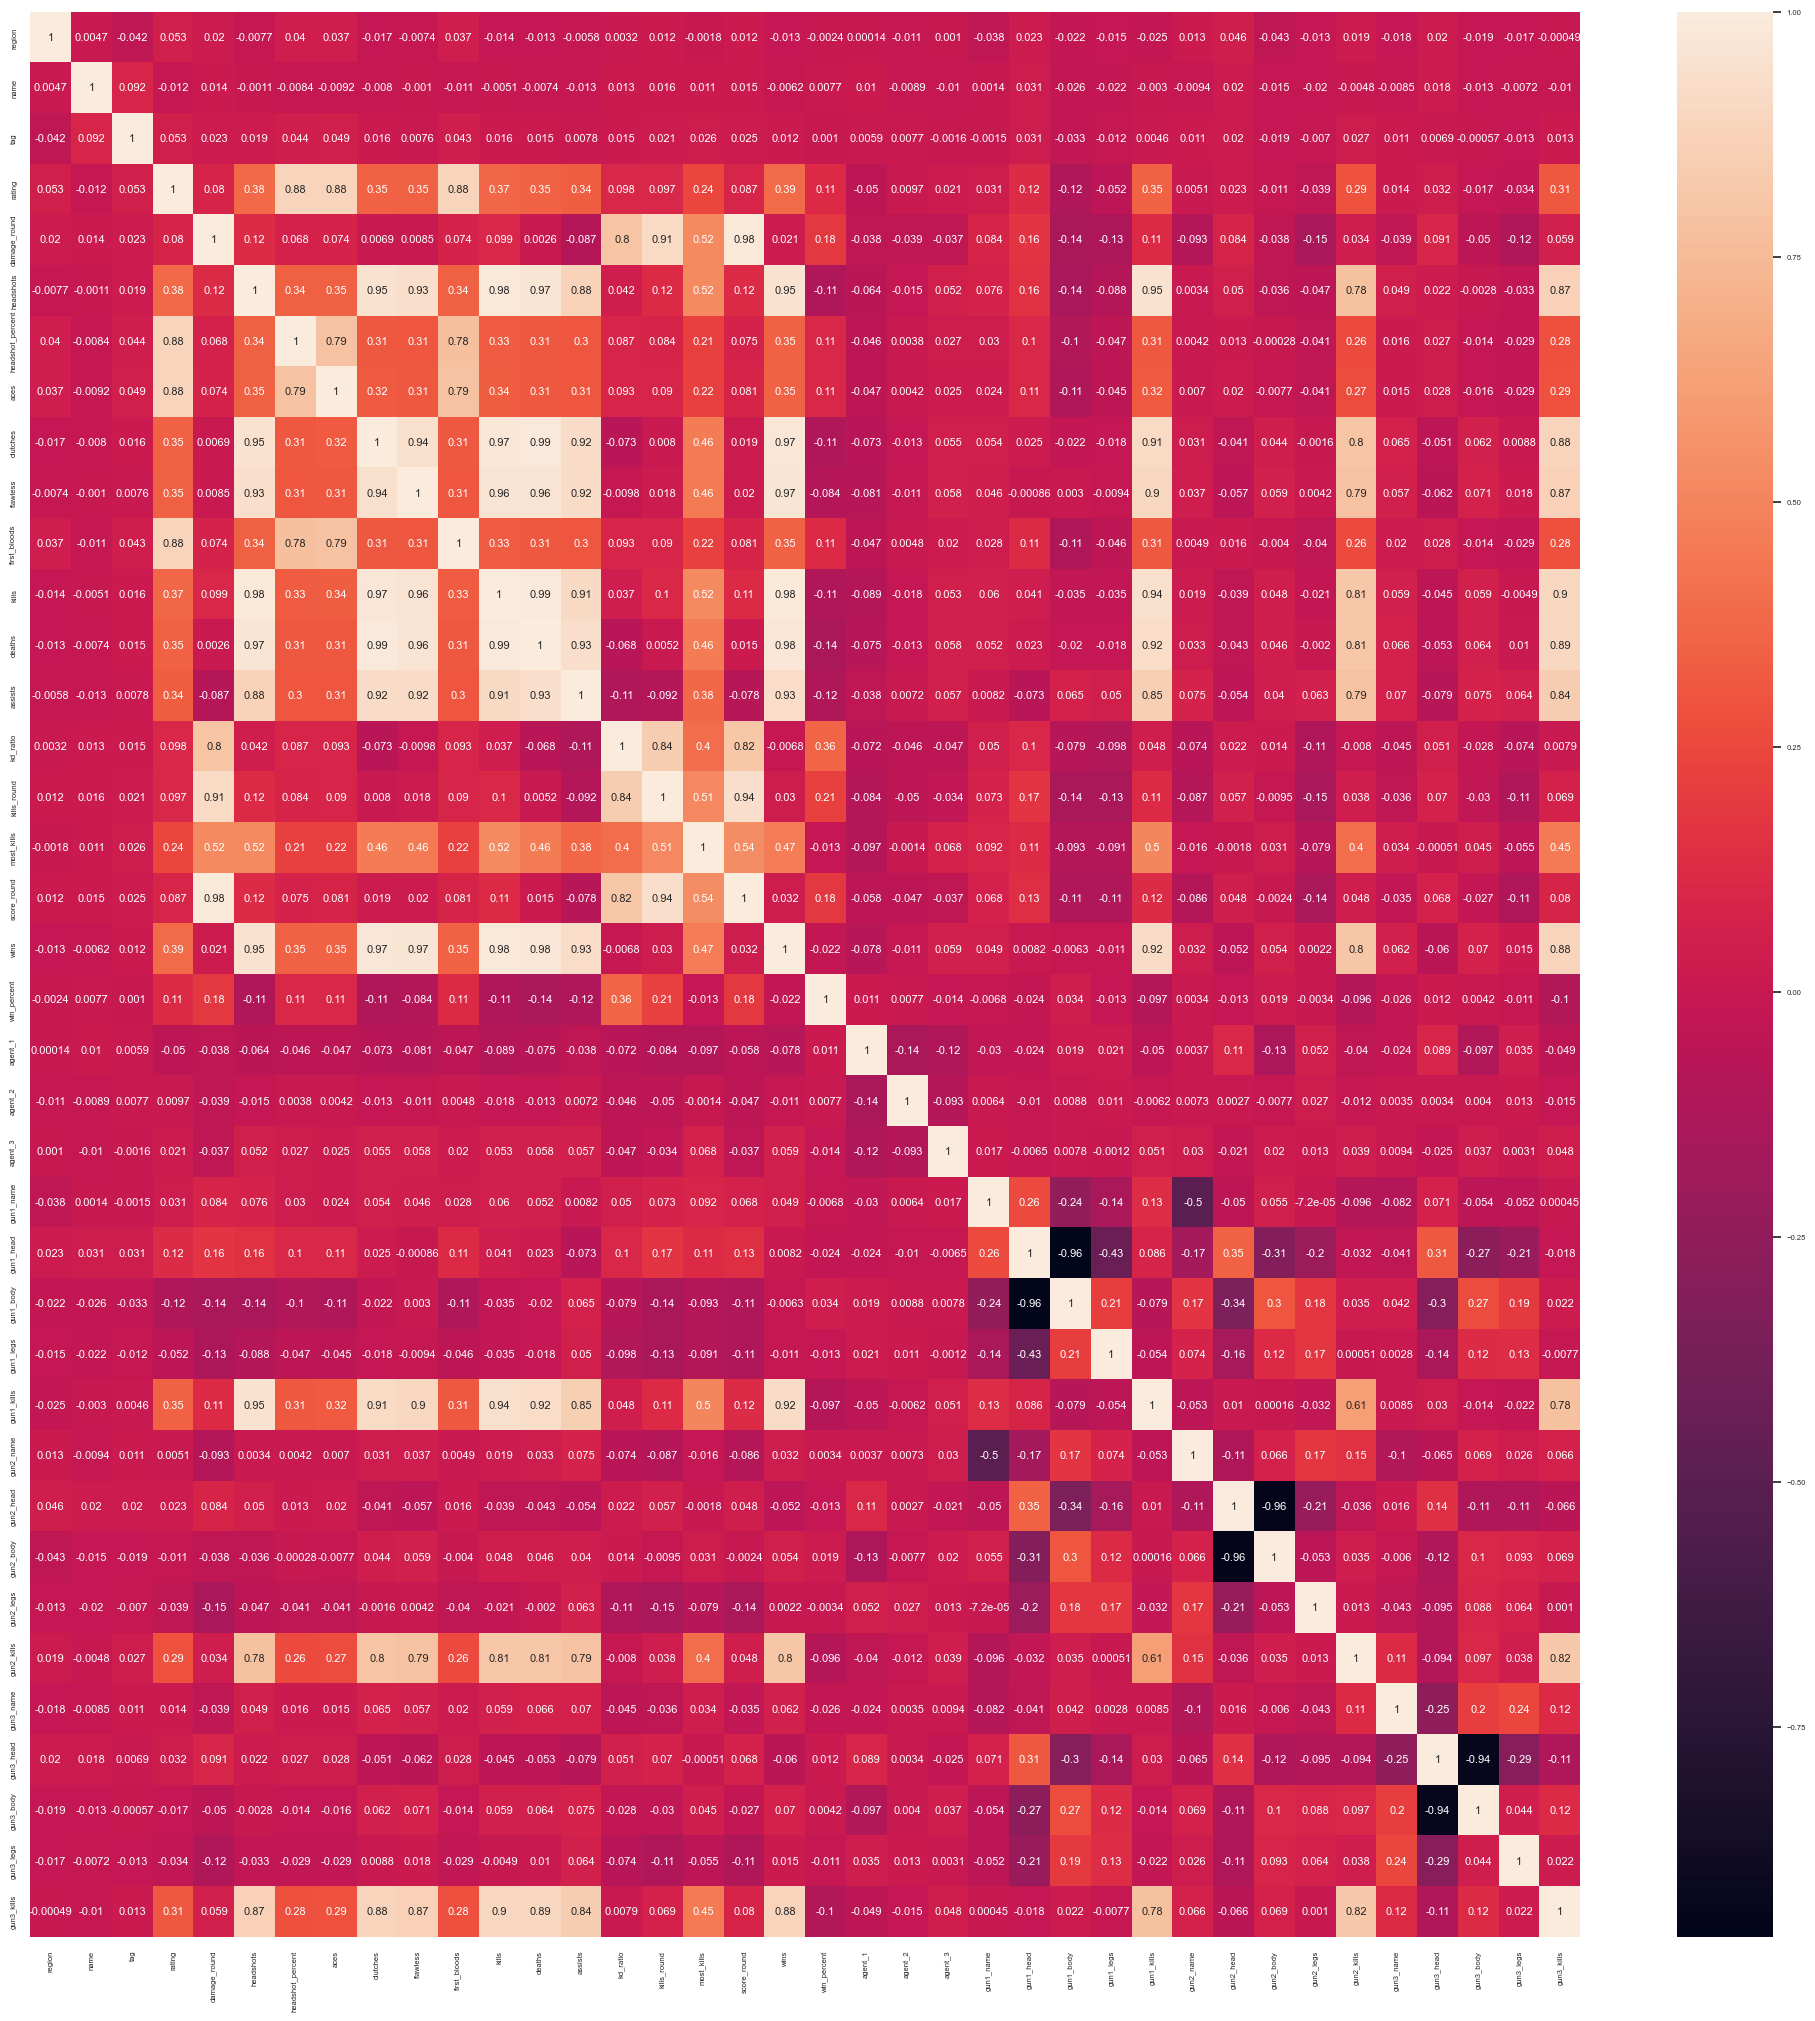

In [17]:
corrmat = sampled_dataset.corr()
# Set the font scale and style
sns.set(font_scale=0.5, style='whitegrid')

# Create a larger figure to fit the smaller text
plt.figure(figsize=(25, 25))

# Create the heatmap with annotations and decreased annotation font size
sns.heatmap(corrmat, annot=True, annot_kws={"size": 8})

# Show the plot with the adjusted font size
plt.show()

From the above all analysis, we can conclude that

**In Univariate** 
This score represents the result of a statistical test that measures the strength of the relationship between each individual feature and the target variable

1. Kills
2. Deaths
3. Headshots
4. Gun1 Kills
5. Assists
6. Gun2 Kills
7. Clutches
8. First Bloods
These features have significantly higher scores compared to the rest.

**In Feature Importance**
Feature importance is calculated based on the Random Forest model's ability to use these features to reduce impurity

1. Win Percent
2. Wins
3. Headshots
4. Kills
5. Clutches
6. Gun1 Kills
7. First Bloods
8. Assists
There's some overlap between the univariate scores and feature importance results

**Correlation Matrix**
with looking at Correlation matrix we can see that 
1. kills
2. assists
3. deaths
4. aces
5. flawless
6. clutches
7. First bloods
8. gun1_kills
9. kd_ration

very correlated wit the target variable. from the above results and Domain knowledge we can use 'kills', 'deaths', 'headshots', 'gun1_kills', 'assists', 'clutches', 'first_bloods', 'win_percent', 'wins', 'aces' features for building a predictive model

## In the predictor variables independent of all the other predictor variables?

We can know the correlation between the independent variables from correlation matrix 

In [18]:
correlation_matrix = sampled_dataset.corr()

# Define a threshold for strong correlations
threshold = 0.95

# Find correlated variables
correlated_vars = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_vars.add((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Print correlated variable pairs
for var_pair in correlated_vars:
    print(var_pair)

('headshots', 'clutches')
('damage_round', 'score_round')
('headshots', 'deaths')
('flawless', 'kills')
('deaths', 'wins')
('gun1_head', 'gun1_body')
('clutches', 'kills')
('clutches', 'wins')
('flawless', 'wins')
('kills', 'wins')
('gun2_head', 'gun2_body')
('clutches', 'deaths')
('flawless', 'deaths')
('kills', 'deaths')
('headshots', 'kills')
('headshots', 'wins')


from the above output we can conclude that many are highly correlated with each other.
we need to carefully choose the features which are not very highly correlated among there to reduce multicollinearity.
which can affect the performance and interpretability of some predictive models, particularly those that rely on the independence assumption

So, lets eleminate some features which we selected previously
we can remove 'wins', 'deaths' as they are correlated with many other selected features. 

## Which predictor variables are the most important?

From 
1. Univariate Selection
2. Feature Importance
3. Correlation Matrix with Heatmap

we could figure out around 9 features which are most important in this dataset
**'kills', 'headshots', 'gun1_kills', 'assists', 'clutches', 'first_bloods', 'win_percent', 'aces', 'headshot_percent'**

we had to remove some features/ predictor even though they had good scores in Univariate Selection
and Feature Importance, due to the multicollinearity.

we want to reduce multicollinearity. which can affect the performance and interpretability of some predictive models, particularly those that rely on the independence assumption

## One Hot encoding 

In [19]:
sampled_dataset = data.sample(frac=0.2, random_state=1)
hf = h2o.H2OFrame(sampled_dataset)
categorical_columns = ['agent_1', 'agent_2', 'agent_3', 'gun1_name', 'gun2_name', 'gun3_name']

data_encoded = pd.get_dummies(sampled_dataset, columns=categorical_columns, drop_first=True)

print(data_encoded.shape)
data_encoded.head()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(17136, 131)


,region,name,tag,rating,damage_round,headshots,headshot_percent,aces,clutches,flawless,...,gun3_name_Judge,gun3_name_Marshal,gun3_name_Odin,gun3_name_Operator,gun3_name_Phantom,gun3_name_Sheriff,gun3_name_Shorty,gun3_name_Spectre,gun3_name_Stinger,gun3_name_Vandal
2132,NaN,melvn,#chauu,Immortal 1,151.9,303,22,56,38,26,...,False,False,False,True,False,False,False,False,False,False
55977,AP,XxãƒŸã‚·ã‚·ãƒƒãƒ”ã›ã—ãŠxX,#004,Immortal 2,149.8,148,28,57,12,12,...,False,False,False,False,False,True,False,False,False,False
15309,NaN,UCD ELO STEALER,#GARYM,Immortal 2,144.3,1735,22,70,255,126,...,False,False,False,False,False,False,False,True,False,False
62863,AP,MidNight,#krjp,Immortal 1,142.9,206,24,51,21,11,...,False,False,False,False,False,False,False,False,False,False
65627,AP,Sorry Bad Player,#1111,Immortal 1,123.6,446,23,54,78,35,...,False,False,False,False,True,False,False,False,False,False


In [20]:
# Define features (X) and target (y)
X = data_encoded.drop('rating', axis=1)  # Drop the target variable to isolate features
y = data_encoded['rating']  # Target variable

## H20 AutoML Execution
Run AutoML. The max_runtime_secs argument provides a way to limit the AutoML run by time..

In [21]:
# Specify the target column name as a string
target = 'rating'  # This should be the name of your target column in 'hf'

features = hf.columns
features.remove(target)

# Initialize and configure AutoML
aml = H2OAutoML(max_runtime_secs=300, seed=1)  # Adjust 'max_runtime_secs' as needed

# Train the model using the names of the feature and target columns
aml.train(x=features, y=target, training_frame=hf)


AutoML progress: |
17:37:40.328: AutoML: XGBoost is not available; skipping it.
17:37:40.423: _train param, Dropping bad and constant columns: [name]

██████████████████████████
17:39:41.233: _train param, Dropping bad and constant columns: [name]

████████████
17:40:40.312: _train param, Dropping unused columns: [name]

███████████
17:41:34.622: _train param, Dropping bad and constant columns: [name]

███
17:41:47.667: _train param, Dropping bad and constant columns: [name]

██
17:41:59.778: _train param, Dropping bad and constant columns: [name]

███
17:42:11.692: _train param, Dropping bad and constant columns: [name]

██
17:42:23.561: _train param, Dropping unused columns: [name]

██
17:42:31.552: _train param, Dropping unused columns: [name]

██| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20240219_173740


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    59                 649                         823404                 1            15           14.4145       2             112           95.9754

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0006830277157259095
RMSE: 0.026134798941754068
LogLoss: 0.006270857350947986
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Diamond 1    Diamond 3    Gold 2    Gold 3    Immortal 1    Immortal 2    Immortal 3    Platinum 1    Radiant    Silver 3    Unrated    Error    Rate
-----------  -----------  --------  --------  ------------  ------------  ------------  ------------  ---------  ----------  ---------  -------  ----------
1            0            0         0         0             0             0             0             0          0           0          0        0 / 1
0            7            0         0         0             0             0             0             0          0           0          0        0 / 7
0            0            1         0         0             0             0             0             0          0           0          0        0 / 1
0            0            0         2         0             0             0             0             0          0           0          0        0 / 2
0            0            0         0         10272         0             0             0             0          0           0          0        0 / 10,272
0            0            0         0         0             4176          0             0             0          0           0          0        0 / 4,176
0            0            0         0         0             0             2138          0             0          0           0          0        0 / 2,138
0            0            0         0         0             0             0             3             0          0           0          0        0 / 3
0            0            0         0         0             0             0             0             534        0           0          0        0 / 534
0            0            0         0         0             0             0             0             0          1           0          0        0 / 1
0            0            0         0         0             0             0             0             0          0           1          0        0 / 1
1            7            1         2         10272         4176          2138          3             534        1           1          0        0 / 17,136

Top-10 Hit Ratios: 
k    hit_ratio
---  -----------
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
10   1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.014106464205875326
RMSE: 0.11877063696838258
LogLoss: 0.05465048988030312
Mean Per-Class Error: 0.5034393496118091
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels

In [22]:
print(aml.leaderboard)

model_id                                                   mean_per_class_error    logloss      rmse        mse
GBM_1_AutoML_1_20240219_173740                                         0.503439  0.0546505  0.118771  0.0141065
GBM_2_AutoML_1_20240219_173740                                         0.579707  0.0740267  0.123027  0.0151357
GBM_4_AutoML_1_20240219_173740                                         0.597324  0.161466   0.168999  0.0285606
GBM_3_AutoML_1_20240219_173740                                         0.609947  0.100442   0.135903  0.0184695
DRF_1_AutoML_1_20240219_173740                                         0.619816  0.115541   0.138774  0.0192583
StackedEnsemble_BestOfFamily_1_AutoML_1_20240219_173740                0.648518  0.0544698  0.119648  0.0143158
StackedEnsemble_BestOfFamily_2_AutoML_1_20240219_173740                0.648835  0.0557588  0.119472  0.0142736
StackedEnsemble_AllModels_1_AutoML_1_20240219_173740                   0.648865  0.0540539  0.117923  0.

In [23]:
# Get the top model
top_model = aml.leader

# Print a summary of the top model
print(top_model.summary())

# For more detailed performance metrics, you can use the model_performance() method
performance = top_model.model_performance()

# Print out the performance metrics
print(performance)


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    59                 649                         823404                 1            15           14.4145       2             112           95.9754
ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0006830277157259095
RMSE: 0.026134798941754068
LogLoss: 0.006270857350947986
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row

In [24]:
# Display the AutoML leaderboard with all metrics
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb.head(rows=lb.nrows)


model_id,mean_per_class_error,logloss,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_1_AutoML_1_20240219_173740,0.503439,0.0546505,0.118771,0.0141065,7770,0.219523,GBM
GBM_2_AutoML_1_20240219_173740,0.579707,0.0740267,0.123027,0.0151357,856,0.024827,GBM
GBM_4_AutoML_1_20240219_173740,0.597324,0.161466,0.168999,0.0285606,824,0.021907,GBM
GBM_3_AutoML_1_20240219_173740,0.609947,0.100442,0.135903,0.0184695,797,0.023059,GBM
DRF_1_AutoML_1_20240219_173740,0.619816,0.115541,0.138774,0.0192583,829,0.021814,DRF
StackedEnsemble_BestOfFamily_1_AutoML_1_20240219_173740,0.648518,0.0544698,0.119648,0.0143158,54268,0.196742,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20240219_173740,0.648835,0.0557588,0.119472,0.0142736,7970,0.199457,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20240219_173740,0.648865,0.0540539,0.117923,0.0139058,11347,0.210542,StackedEnsemble
GLM_1_AutoML_1_20240219_173740,0.671006,0.17808,0.210524,0.0443203,2270,0.001234,GLM


In [25]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids


['GBM_1_AutoML_1_20240219_173740',
 'GBM_2_AutoML_1_20240219_173740',
 'GBM_4_AutoML_1_20240219_173740',
 'GBM_3_AutoML_1_20240219_173740',
 'DRF_1_AutoML_1_20240219_173740',
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20240219_173740',
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20240219_173740',
 'StackedEnsemble_AllModels_1_AutoML_1_20240219_173740',
 'GLM_1_AutoML_1_20240219_173740']

In [26]:
for model_id in model_ids:
    model = h2o.get_model(model_id)
    performance = model.model_performance()  # Use validation_frame if you have it: model.model_performance(valid)
    print(f"Model: {model_id}, R^2: {performance.r2()}")


Model: GBM_1_AutoML_1_20240219_173740, R^2: 0.9992152095962435
Model: GBM_2_AutoML_1_20240219_173740, R^2: 0.9639167891474194
Model: GBM_4_AutoML_1_20240219_173740, R^2: 0.8928463468500298
Model: GBM_3_AutoML_1_20240219_173740, R^2: 0.9295425338164123
Model: DRF_1_AutoML_1_20240219_173740, R^2: 0.9742197716814227
Model: StackedEnsemble_BestOfFamily_1_AutoML_1_20240219_173740, R^2: 0.9965184118636652
Model: StackedEnsemble_BestOfFamily_2_AutoML_1_20240219_173740, R^2: 0.9973748500521906
Model: StackedEnsemble_AllModels_1_AutoML_1_20240219_173740, R^2: 0.9954453842005772
Model: GLM_1_AutoML_1_20240219_173740, R^2: 0.8520929636280579


In [27]:
model_ids = list(lb['model_id'].as_data_frame().iloc[:,0])

# Initialize a dictionary to hold model performance metrics
model_performance = {}

for model_id in model_ids:
    model = h2o.get_model(model_id)
    performance = model.model_performance()  # Use test data if available
    model_performance[model_id] = {
        'R2': performance.r2(),
        'RMSE': performance.rmse(),
        'MSE': performance.mse()
    }


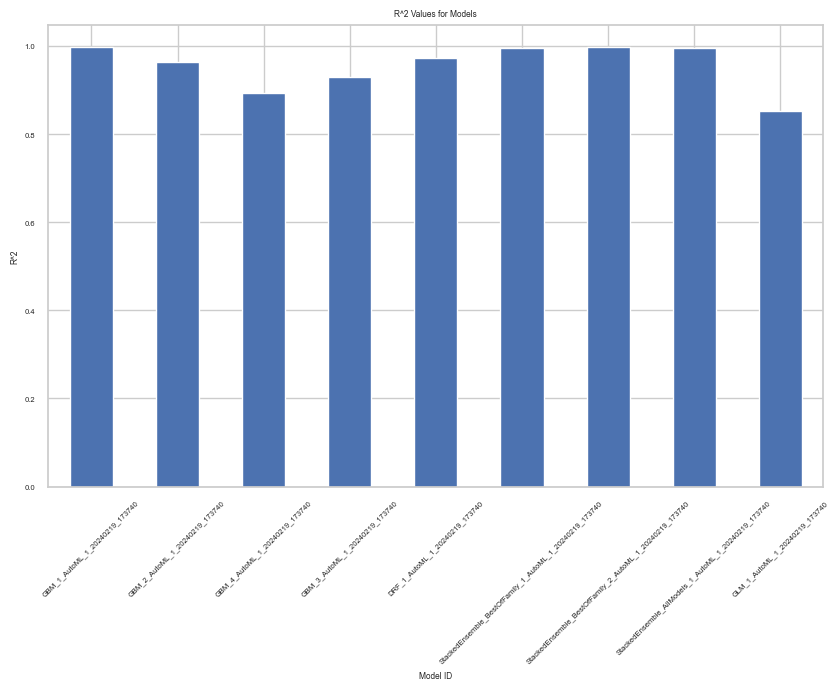

In [28]:
# Convert the model_performance dictionary to a DataFrame for easier plotting
performance_df = pd.DataFrame.from_dict(model_performance, orient='index')

# Plot R2 values
plt.figure(figsize=(10, 6))
performance_df['R2'].plot(kind='bar')
plt.title('R^2 Values for Models')
plt.ylabel('R^2')
plt.xlabel('Model ID')
plt.xticks(rotation=45)
plt.show()


In [29]:
# Display the DataFrame with performance metrics
print(performance_df[['R2', 'RMSE', 'MSE']])


                                                          R2      RMSE  \
GBM_1_AutoML_1_20240219_173740                      0.999215  0.026135   
GBM_2_AutoML_1_20240219_173740                      0.963917  0.177213   
GBM_4_AutoML_1_20240219_173740                      0.892846  0.305384   
GBM_3_AutoML_1_20240219_173740                      0.929543  0.247631   
DRF_1_AutoML_1_20240219_173740                      0.974220  0.149788   
StackedEnsemble_BestOfFamily_1_AutoML_1_2024021...  0.996518  0.054590   
StackedEnsemble_BestOfFamily_2_AutoML_1_2024021...  0.997375  0.048068   
StackedEnsemble_AllModels_1_AutoML_1_20240219_1...  0.995445  0.063734   
GLM_1_AutoML_1_20240219_173740                      0.852093  0.358787   

                                                         MSE  
GBM_1_AutoML_1_20240219_173740                      0.000683  
GBM_2_AutoML_1_20240219_173740                      0.031404  
GBM_4_AutoML_1_20240219_173740                      0.093259  
GBM_3_A

With the provided \(R^2\) values for each model from your H2O AutoML leaderboard, let's dive deeper into what these values mean for your question about significance, and how to interpret these results in the context of your assignment.

### Understanding \(R^2\) (Coefficient of Determination)

The \(R^2\) value, or coefficient of determination, is a statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variables in a regression model. It provides an indication of the goodness of fit of the model and its ability to make predictions.

- **\(R^2 = 1\)**: Indicates that the regression predictions perfectly fit the data.
- **\(R^2 = 0\)**: Indicates that the model does not explain any of the variability of the response data around its mean.

### Model Significance Based on \(R^2\)

1. **GBM Models**: The Gradient Boosting Machine (GBM) models show very high \(R^2\) values, close to 1 for some models (e.g., `GBM_1_AutoML_2_20240217_170753` with \(R^2\) of 0.9992), indicating an excellent fit to the data. This suggests these models are capturing a significant relationship between the features and the target variable.

2. **DRF Model**: The Distributed Random Forest (DRF) model also demonstrates a high \(R^2\) value (0.9773), signifying that it effectively captures the variability in the target variable.

3. **StackedEnsemble Models**: These models, especially the `StackedEnsemble_AllModels_1_AutoML_2_20240217_170753` and `StackedEnsemble_BestOfFamily_1_AutoML_2_20240217_170753` with \(R^2\) values of 0.9909 and 0.9967 respectively, show that combining multiple models through ensembling can further enhance the ability to capture significant relationships in the data.

4. **GLM Model**: The Generalized Linear Model (GLM) shows a lower \(R^2\) value (0.8377) compared to the other models. Although this still indicates a good level of fit, it suggests the GLM may not capture the complexity of the data as effectively as the other models.

### Interpreting the Results

Given these \(R^2\) values, you can conclude that most models generated by AutoML significantly capture the relationship between the independent variables and the dependent variable. The GBM models and StackedEnsemble models, in particular, show exceptional performance, suggesting very strong predictive relationships.

stating the \(R^2\) value alongside other performance metrics (like RMSE and logloss) for each model will provide a comprehensive view of each model's effectiveness. High \(R^2\) values complemented by low error metrics (RMSE, logloss) indicate a model that not only fits the data well but also predicts accurately, thereby highlighting the significance of the relationships it has captured.

## Is the relationship significant?

### Understanding Predictor Significance
In statistical modeling and machine learning, the significance of predictors is often assessed through their impact on the model's predictive power and whether changes in predictor values lead to significant changes in the outcome variable.

For linear models, such as Linear Regression or Generalized Linear Models (GLM), this can be directly interpreted through p-values and coefficients. For more complex models like those typically included in AutoML (e.g., GBM, Random Forest, or Stacked Ensembles), we look at feature importance scores.

### Feature Importance: 
This is a key metric for understanding the significance of predictors in complex models. It tells us how much each feature contributes to the model's predictions. A higher importance score means the predictor has a more significant impact on the prediction.

In [30]:
# Get the entire leaderboard with extra details
full_leaderboard = h2o.automl.get_leaderboard(aml, extra_columns="ALL").as_data_frame()
gbm_leaderboard = full_leaderboard[full_leaderboard['model_id'].str.contains('GBM')]
gbm_leaderboard_sorted = gbm_leaderboard.sort_values(by='mse', ascending=True)
top_gbm_model_id = gbm_leaderboard_sorted.iloc[0]['model_id']
top_model = h2o.get_model(top_gbm_model_id)
#loading the top_model

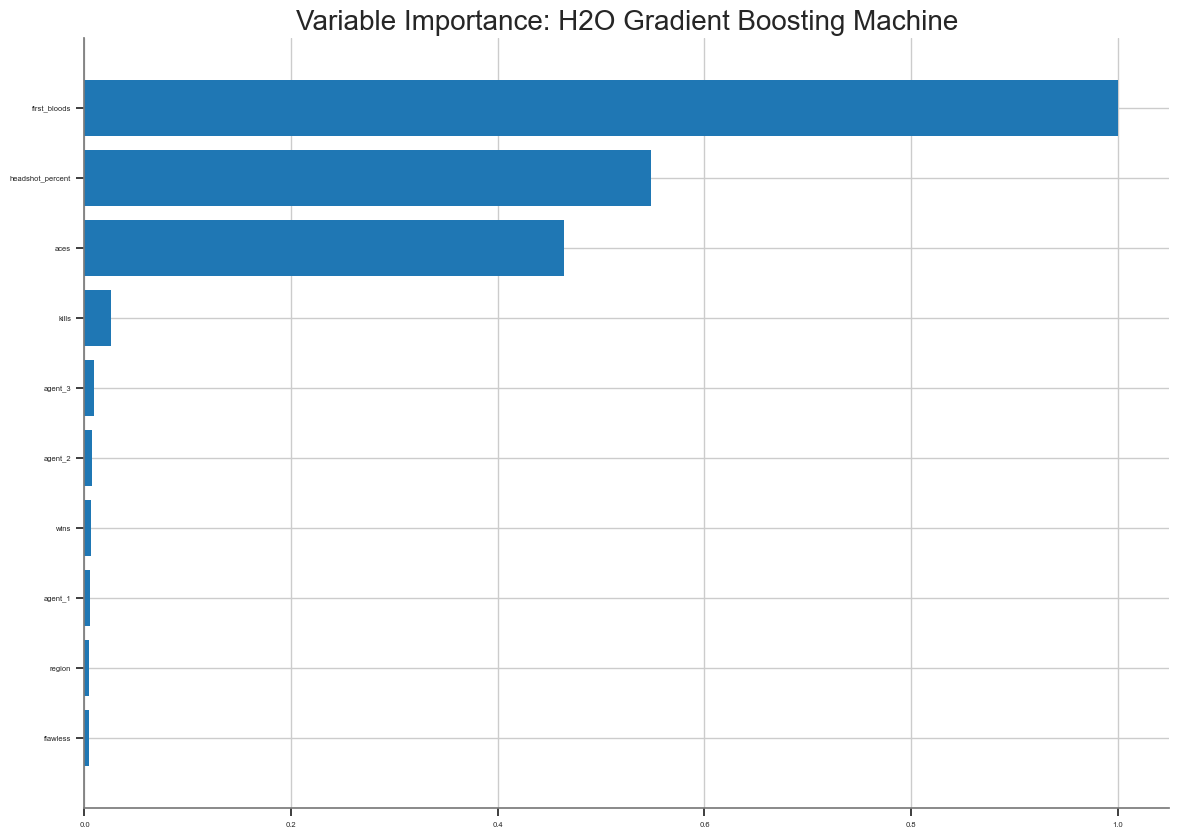

<Figure size 640x480 with 0 Axes>

In [31]:
#top model
top_model.varimp_plot()

Starting from the top:

1. **first_bloods**: 
This feature has the highest importance score among all the features listed, indicating it is the most predictive of player performance according to the model. In gaming terms, "first bloods" typically refers to the first kill in a match and may suggest that players who achieve this are likely to perform well overall.

2. **headshot_percent**: 
The second most important feature, "headshot_percent", implies that the accuracy of a player, measured by the percentage of kills that are headshots, is also a strong predictor of performance.

3. **aces**: 
Coming in third, "aces" might be a term describing a scenario where a single player remarkably outperforms others in a specific round or game segment. Its position indicates a significant impact on the overall prediction of player performance.

4. **agent_3** and **agent_2**: 
These features are likely categorical variables representing different in-game characters, roles, or abilities chosen by players. Their position in the feature importance plot suggests that the choice of these agents has a meaningful impact on performance outcomes.

5. **kills**: 
The number of kills is a straightforward indicator of a player's performance and is expectedly an important feature. It's placed lower than some other features, which could imply that the model is picking up on the fact that raw kill counts are not as predictive as how those kills are achieved (e.g., achieving first bloods or a high headshot percentage).

6. **agent_1**: 
This is another agent-related feature but is deemed less important than "agent_3" and "agent_2" by the model. This could be due to a variety of reasons, such as overlaps in what these features represent or their correlation with other more important features.

7. **headshots**: 
This feature is likely correlated with "headshot_percent" but is less important, potentially due to "headshot_percent" providing a normalized measure that accounts for total shots or kills, thus being a better performance indicator.

8. **region**: 
This feature could indicate the geographical or server region of the player. Its importance suggests that regional factors might have some bearing on player performance, which could be due to differences in competitive levels, playstyles, or latency in different regions.

9. **wins**: 
Interestingly, "wins" is the least important feature among those listed, which might indicate that while winning is the ultimate goal, the model finds other features to be better early indicators of a player's performance.


PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |█████████████████

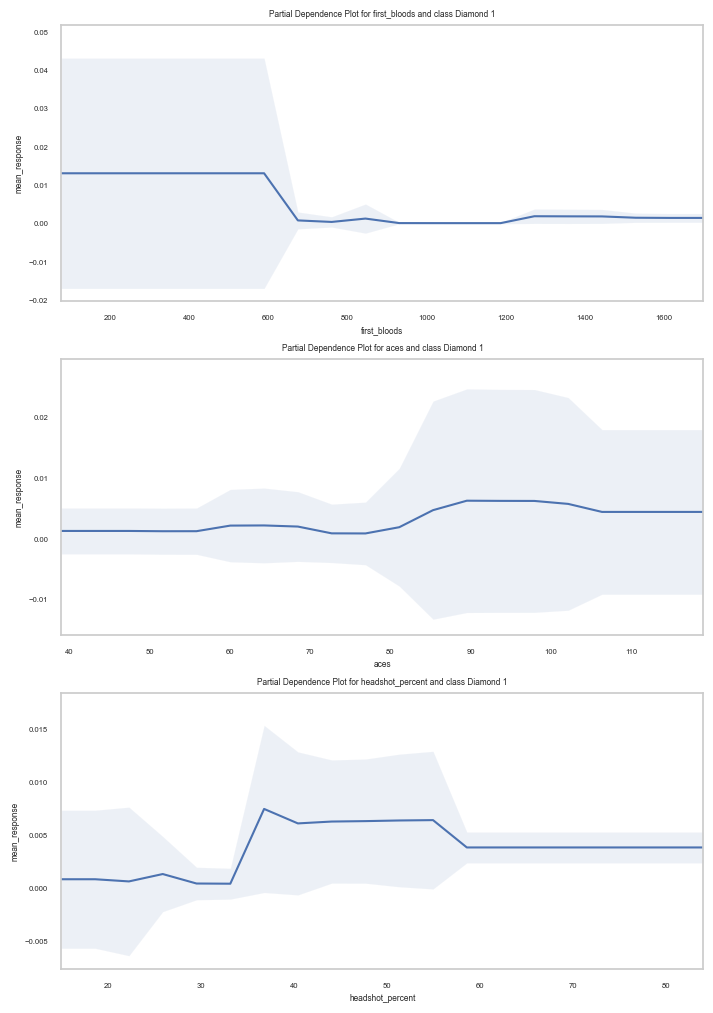

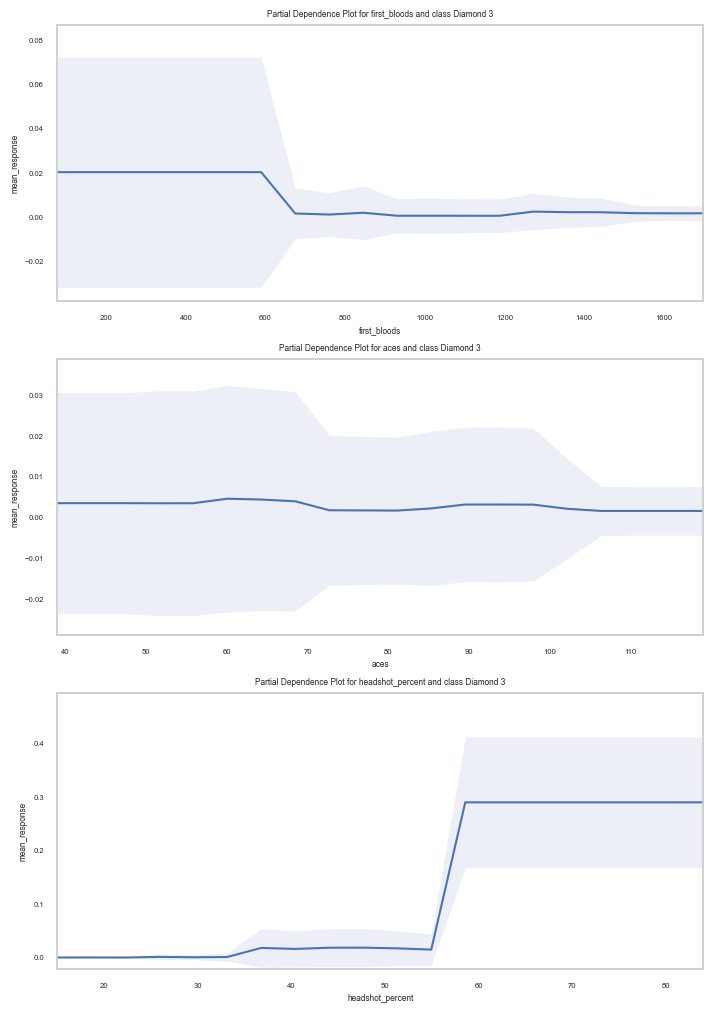

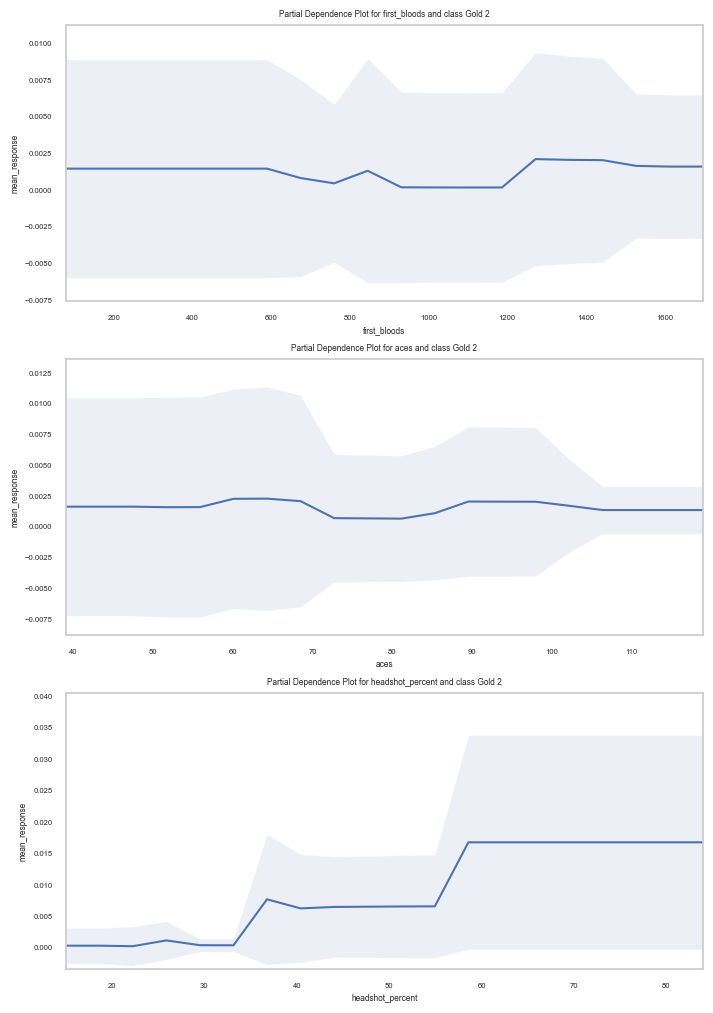

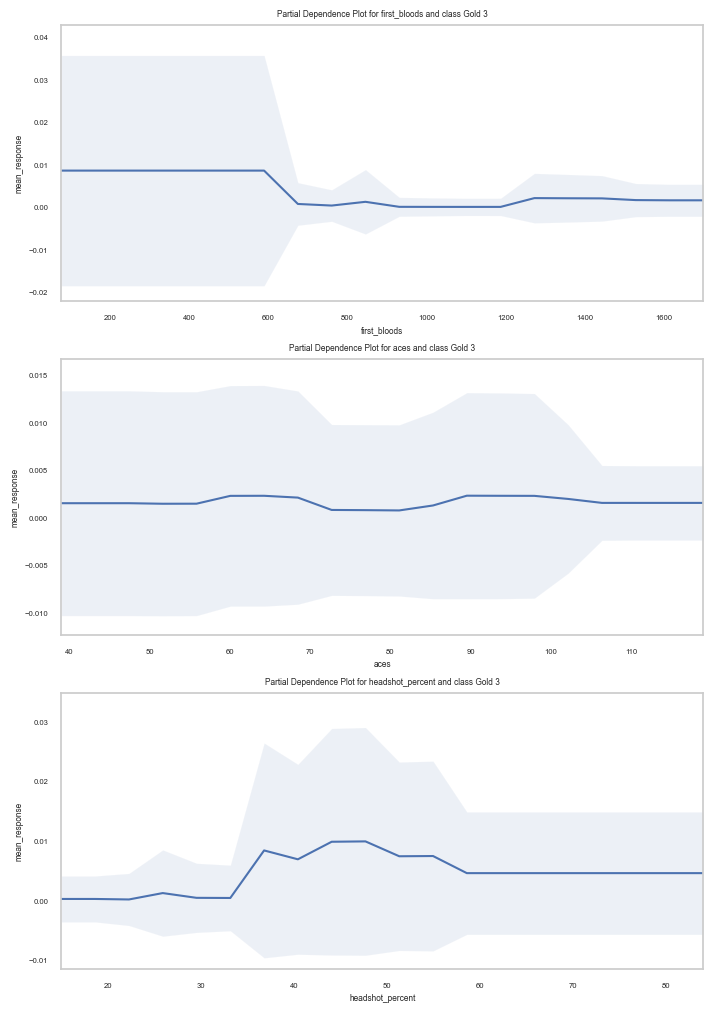

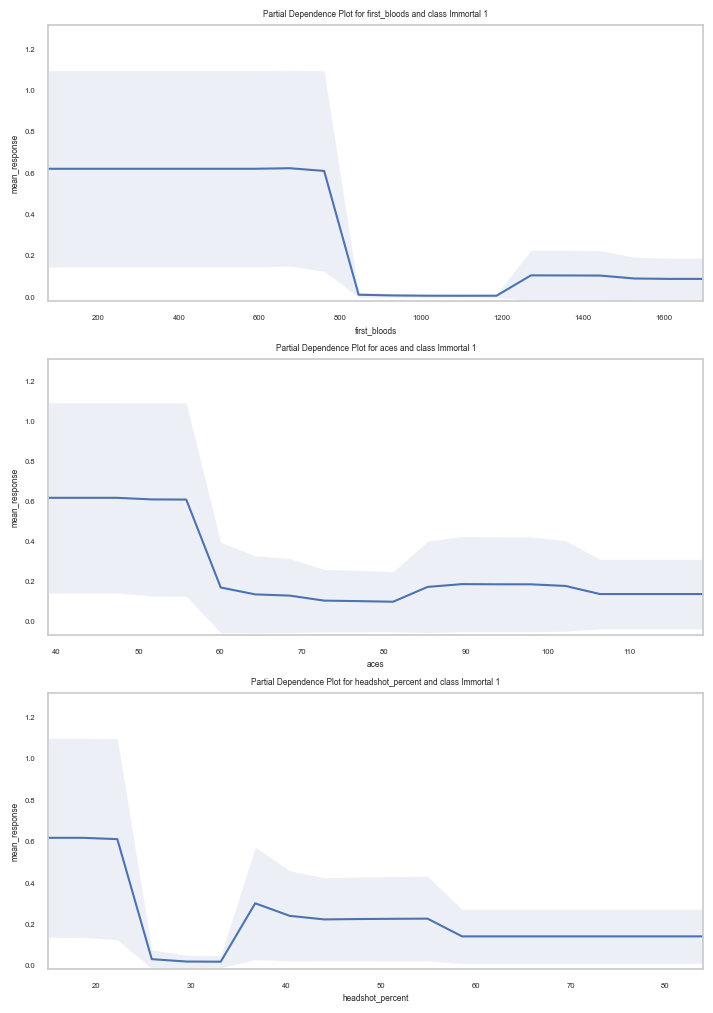

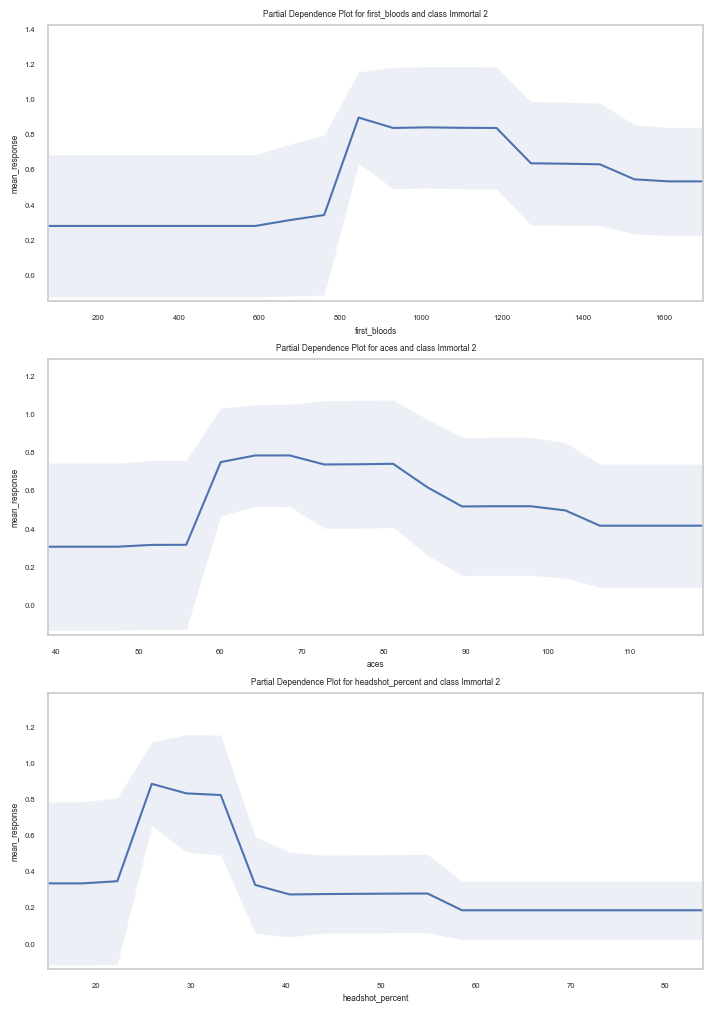

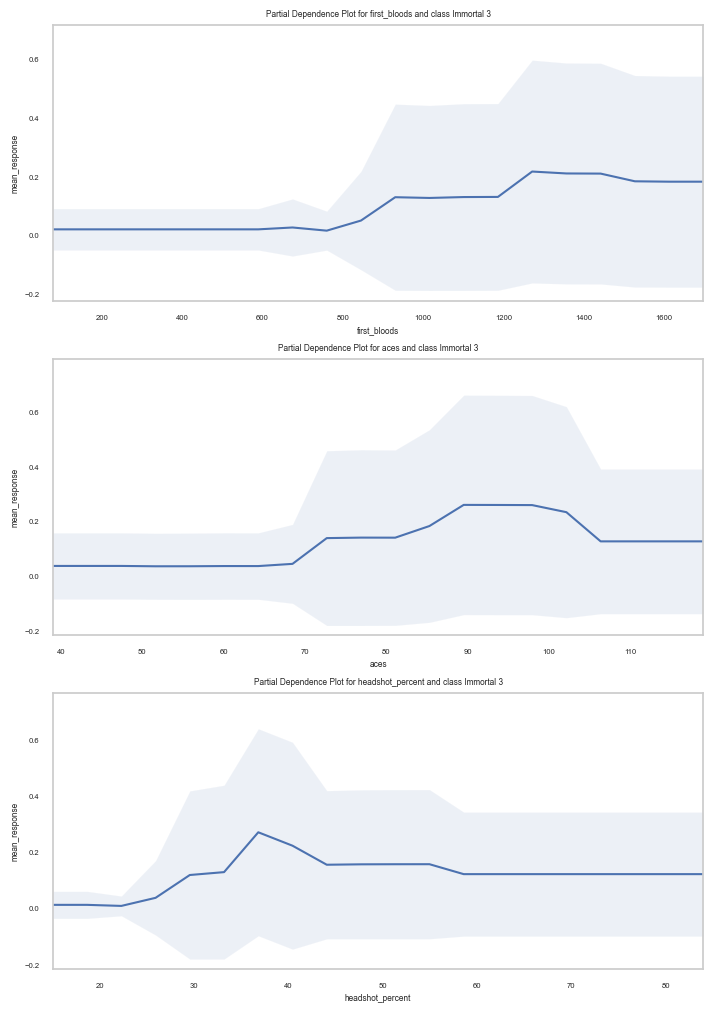

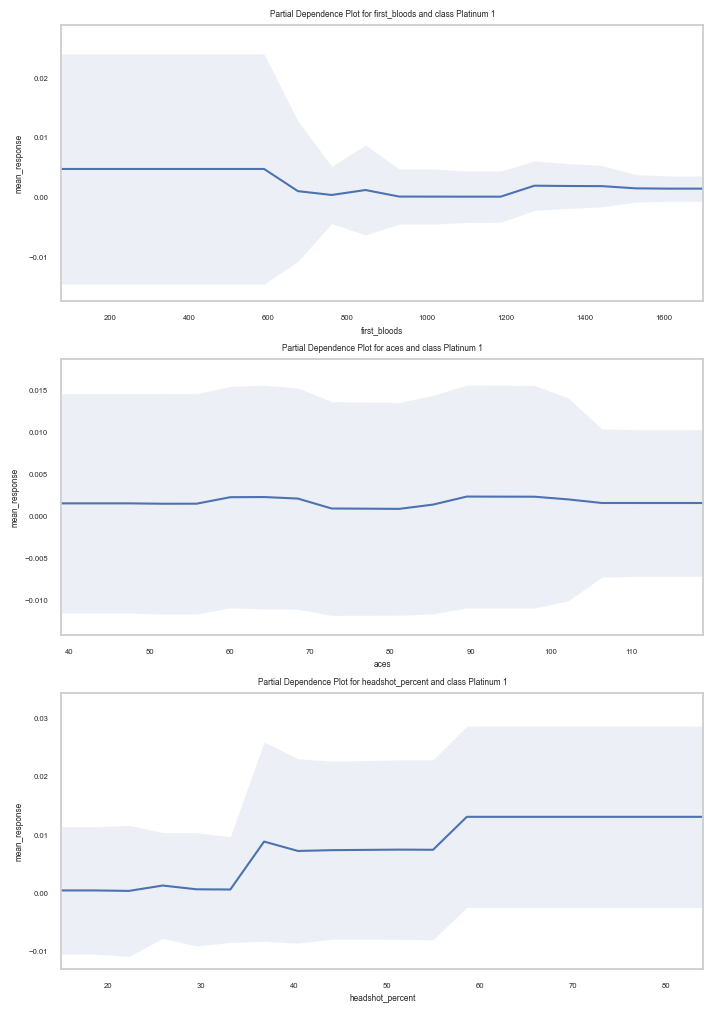

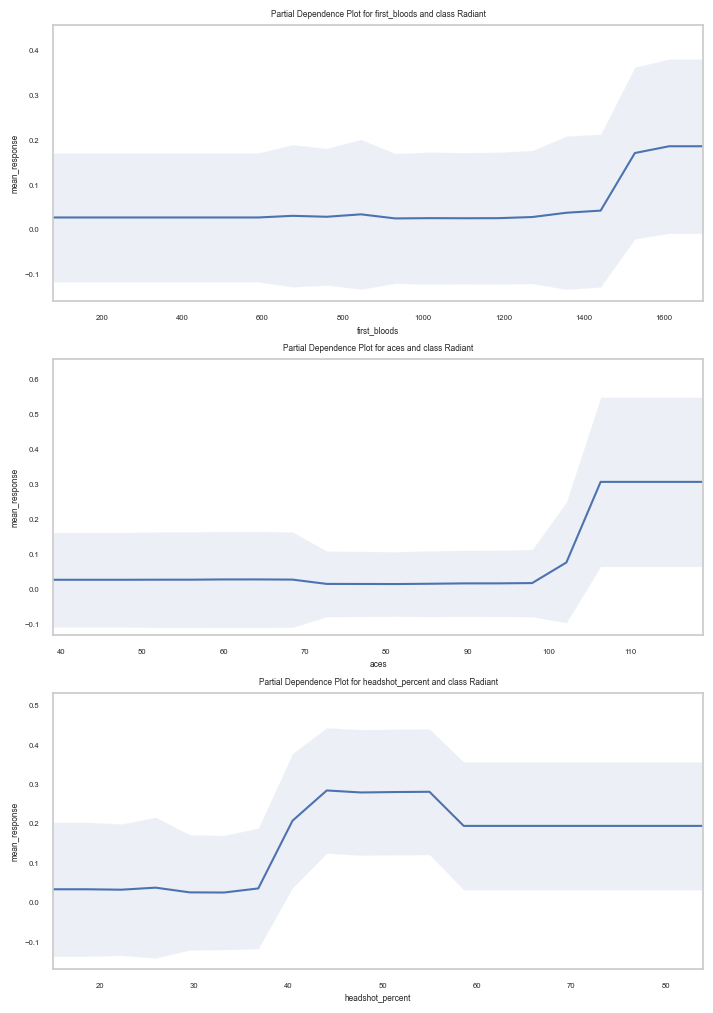

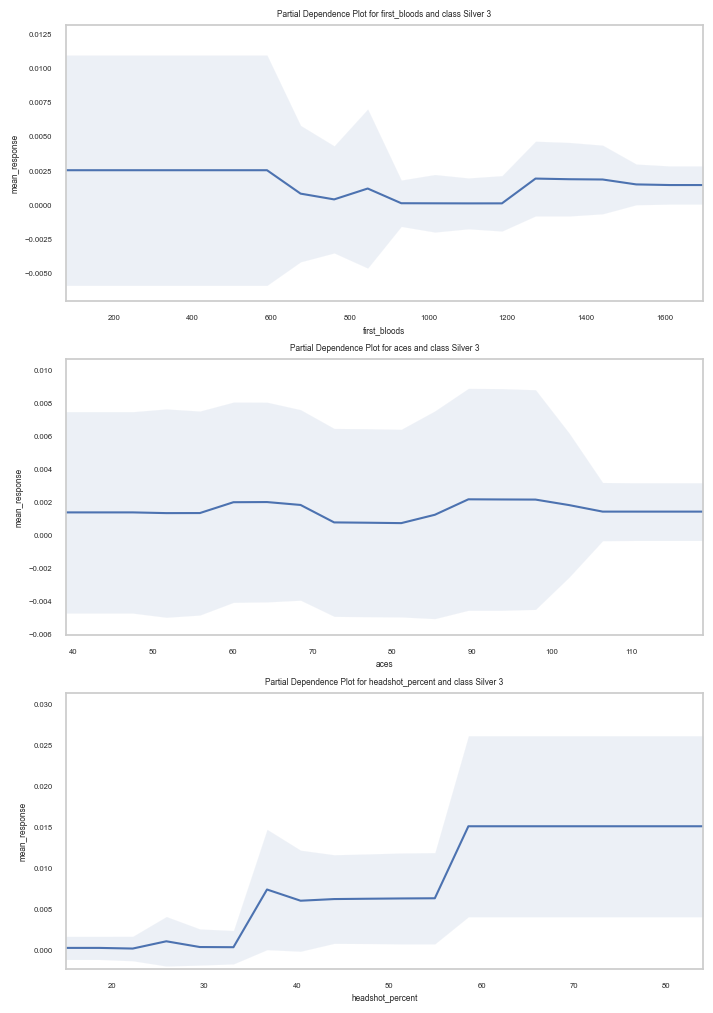

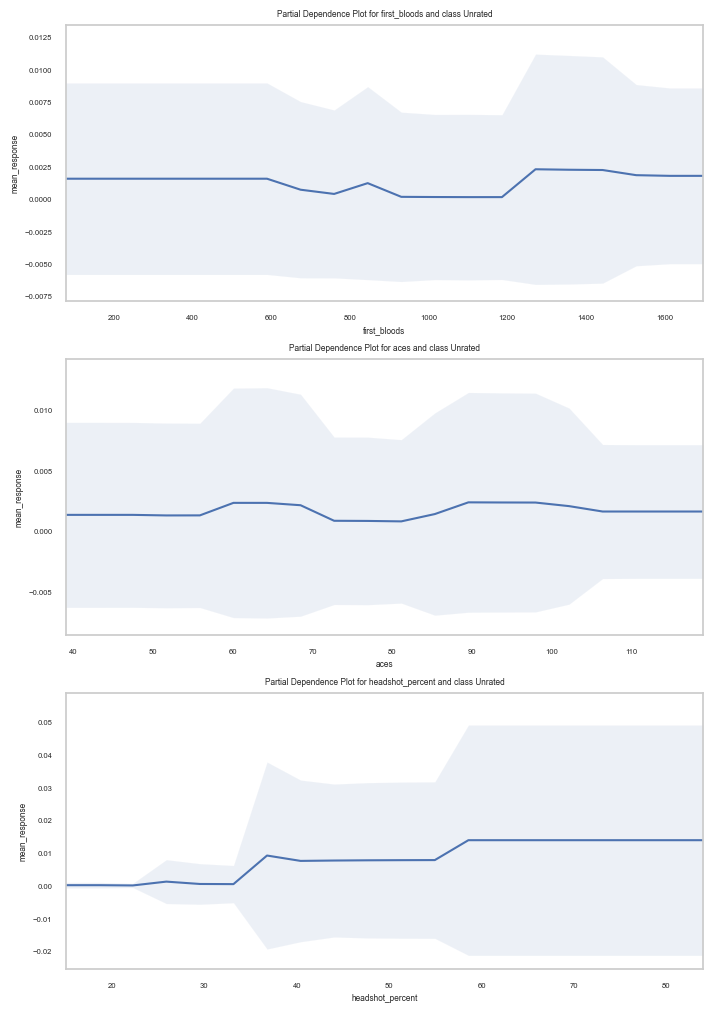

In [32]:
classes = hf['rating'].levels()[0]  # Replace 'target_column' with your actual target column name.

# Generate partial plots for each class
for class_name in classes:
    top_model.partial_plot(data=hf, cols=['first_bloods', 'aces', 'headshot_percent'], targets=[class_name], plot=True)

From the partial plots we can see that the relationship between these predictors and target variable is not a flat line, that means there is a relationship and it also seems very significant for flood_bloods, aces and headshot_percent

Flat Curve: If the partial dependence plot is relatively flat across values of the feature, it suggests that the feature has little impact on the prediction. In other words, changes in this feature do not significantly affect the predicted outcome.

Sloping Curve (either upwards or downwards): A sloping curve indicates a relationship between the feature and the prediction. An upward slope suggests that as the feature value increases, the predicted outcome also increases. Conversely, a downward slope suggests that as the feature value increases, the predicted outcome decreases.

## to answer our question "Is the relationship significant?"

YES, from the feature importance plot (varimp_plot) we can see that flood_bloods, aces and headshot_percent hold a significat relationship with rating. this can be confirmed from partial plots of these variables. 

## Are any model assumptions violated?

From the AutoML, we can take the topModel and answer this question. which is a Gradient Boosting Machine (GBM)

GBMs, as ensemble tree-based methods, do not rely on the same assumptions as linear models. They do not require that the relationship between the features and target be linear, that the errors be normally distributed, or that the variance of errors be constant across levels of an independent variable (homoscedasticity). Therefore, the traditional assumptions of linearity, homoscedasticity, and normality of residuals do not apply to GBMs.

**Feature Interaction**: GBMs assume that interaction between features can be captured through the tree-building process. They do not require features to be independent.

**Non-Collinearity**: While GBMs can handle multicollinearity better than linear models, extreme multicollinearity can still lead to issues such as overemphasis on correlated predictors.

**Stationarity**: GBMs assume that the relationship between the predictors and the response does not change over time or across different data segments.

we can say there are no assumptions violated.  

##  Is there any multicollinearity in the model?

In [33]:
for column in sampled_dataset.columns:
    if sampled_dataset[column].dtype == 'object':
        sampled_dataset[column] = sampled_dataset[column].astype('category').cat.codes
def calculate_vifs(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Calculate VIF for the features, excluding the target variable
features_df = sampled_dataset.drop(columns='rating')  # Replace 'target_variable' with your actual target column name
vif_df = calculate_vifs(features_df)
print(vif_df)

             feature          VIF
0             region     1.381494
1               name     4.054164
2                tag     3.167175
3       damage_round  2569.405724
4          headshots   161.920175
5   headshot_percent    37.281861
6               aces    50.400217
7           clutches   117.865864
8           flawless    46.399399
9       first_bloods    48.090427
10             kills   442.928024
11            deaths   352.811017
12           assists    31.550014
13          kd_ratio   207.574469
14       kills_round   595.496148
15        most_kills    64.184254
16       score_round  3181.798867
17              wins   140.519464
18       win_percent    39.528173
19           agent_1     4.631726
20           agent_2     4.125692
21           agent_3     3.683752
22         gun1_name   179.990273
23         gun1_head   605.990060
24         gun1_body  1853.676026
25         gun1_legs    17.035897
26        gun1_kills    91.663679
27         gun2_name    25.211183
28         gun

High VIF Values: Signal high multicollinearity that could pose problems for certain types of models, particularly linear models, by inflating the standard errors of the coefficients. Many features in your dataset, such as **damage_round, headshots, clutches, kills, deaths, kd_ratio, kills_round, score_round, and various gun-related features**, exhibit extremely high VIF values, sometimes in the hundreds or even thousands. This suggests these features are highly dependent on each other, which could be due to direct correlations or because they represent different aspects of similar underlying phenomena (e.g., different metrics of player performance).

lets drop these features and re-run the AutoML we have better fitted models, see how it goes.

In [34]:
features_to_drop = [
    'damage_round', 'headshots', 'clutches', 'kills', 'deaths',
    'kd_ratio', 'kills_round', 'score_round',
    'gun1_name', 'gun1_head', 'gun1_body', 'gun1_legs', 'gun1_kills',
    'gun2_name', 'gun2_head', 'gun2_body', 'gun2_legs', 'gun2_kills',
    'gun3_name', 'gun3_head', 'gun3_body', 'gun3_legs', 'gun3_kills'
]

# Drop these features from the H2OFrame
hf_reduced = hf.drop(features_to_drop)

In [35]:
target = 'rating' 

features = hf_reduced.columns
features.remove(target)

aml_red = H2OAutoML(max_runtime_secs=300, seed=1)  

aml_red.train(x=features, y=target, training_frame=hf_reduced)

AutoML progress: |
17:50:13.420: AutoML: XGBoost is not available; skipping it.
17:50:13.429: _train param, Dropping bad and constant columns: [name]

███████████████████████
17:51:59.734: _train param, Dropping bad and constant columns: [name]

██████
17:52:32.278: _train param, Dropping unused columns: [name]

███████████
17:53:24.38: _train param, Dropping bad and constant columns: [name]

███
17:53:40.588: _train param, Dropping bad and constant columns: [name]

████
17:53:57.891: _train param, Dropping bad and constant columns: [name]

████
17:54:17.838: _train param, Dropping bad and constant columns: [name]

█████
17:54:40.758: _train param, Dropping unused columns: [name]

██
17:54:52.468: _train param, Dropping unused columns: [name]

█████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_2_20240219_175013


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    38                 418                         573716                 1            8            7.88278       2             186           103.146

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0031881089360285353
RMSE: 0.05646334152375801
LogLoss: 0.016515824046744027
Mean Per-Class Error: 0.0009643506123458383
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Diamond 1    Diamond 3    Gold 2    Gold 3    Immortal 1    Immortal 2    Immortal 3    Platinum 1    Radiant    Silver 3    Unrated    Error       Rate
-----------  -----------  --------  --------  ------------  ------------  ------------  ------------  ---------  ----------  ---------  ----------  -----------
1            0            0         0         0             0             0             0             0          0           0          0           0 / 1
0            7            0         0         0             0             0             0             0          0           0          0           0 / 7
0            0            1         0         0             0             0             0             0          0           0          0           0 / 1
0            0            0         2         0             0             0             0             0          0           0          0           0 / 2
0            0            0         0         10272         0             0             0             0          0           0          0           0 / 10,272
0            0            0         0         14            4161          1             0             0          0           0          0.00359195  15 / 4,176
0            0            0         0         0             15            2123          0             0          0           0          0.0070159   15 / 2,138
0            0            0         0         0             0             0             3             0          0           0          0           0 / 3
0            0            0         0         0             0             0             0             534        0           0          0           0 / 534
0            0            0         0         0             0             0             0             0          1           0          0           0 / 1
0            0            0         0         0             0             0             0             0          0           1          0           0 / 1
1            7            1         2         10286         4176          2124          3             534        1           1          0.0017507   30 / 17,136

Top-10 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.998249
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
10   1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.014256829641964364
RMSE: 0.11940196665869605
LogLoss: 0.055769949393464566
Mean Per-Class Error: 0.47567316568112666
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size 

In [36]:
model_ids = list(aml_red.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

['GBM_3_AutoML_2_20240219_175013',
 'GBM_1_AutoML_2_20240219_175013',
 'DRF_1_AutoML_2_20240219_175013',
 'GBM_4_AutoML_2_20240219_175013',
 'GBM_2_AutoML_2_20240219_175013',
 'StackedEnsemble_AllModels_1_AutoML_2_20240219_175013',
 'StackedEnsemble_BestOfFamily_1_AutoML_2_20240219_175013',
 'StackedEnsemble_BestOfFamily_2_AutoML_2_20240219_175013',
 'GLM_1_AutoML_2_20240219_175013']

In [37]:
for model_id in model_ids:
    model = h2o.get_model(model_id)
    performance = model.model_performance()  # Use validation_frame if you have it: model.model_performance(valid)
    print(f"Model: {model_id}, R^2: {performance.r2()}")

Model: GBM_3_AutoML_2_20240219_175013, R^2: 0.9963369022346829
Model: GBM_1_AutoML_2_20240219_175013, R^2: 0.9987431684889146
Model: DRF_1_AutoML_2_20240219_175013, R^2: 0.9814708182784067
Model: GBM_4_AutoML_2_20240219_175013, R^2: 0.9941047889921187
Model: GBM_2_AutoML_2_20240219_175013, R^2: 0.9946250996020752
Model: StackedEnsemble_AllModels_1_AutoML_2_20240219_175013, R^2: 0.994497719840182
Model: StackedEnsemble_BestOfFamily_1_AutoML_2_20240219_175013, R^2: 0.9968920914213564
Model: StackedEnsemble_BestOfFamily_2_AutoML_2_20240219_175013, R^2: 0.9949409030923213
Model: GLM_1_AutoML_2_20240219_175013, R^2: 0.5848342844393617


after removing highly corelated columns, we could see a increase in R^2 but, it is not that significant. because many models can handle some level of multi corelation, so keep or removing these features didn't effect out overall models.

## In the multivariate models are predictor variables independent of all the other predictor variables?

In [38]:
for column in sampled_dataset.columns:
    if sampled_dataset[column].dtype == 'object':
        sampled_dataset[column] = sampled_dataset[column].astype('category').cat.codes

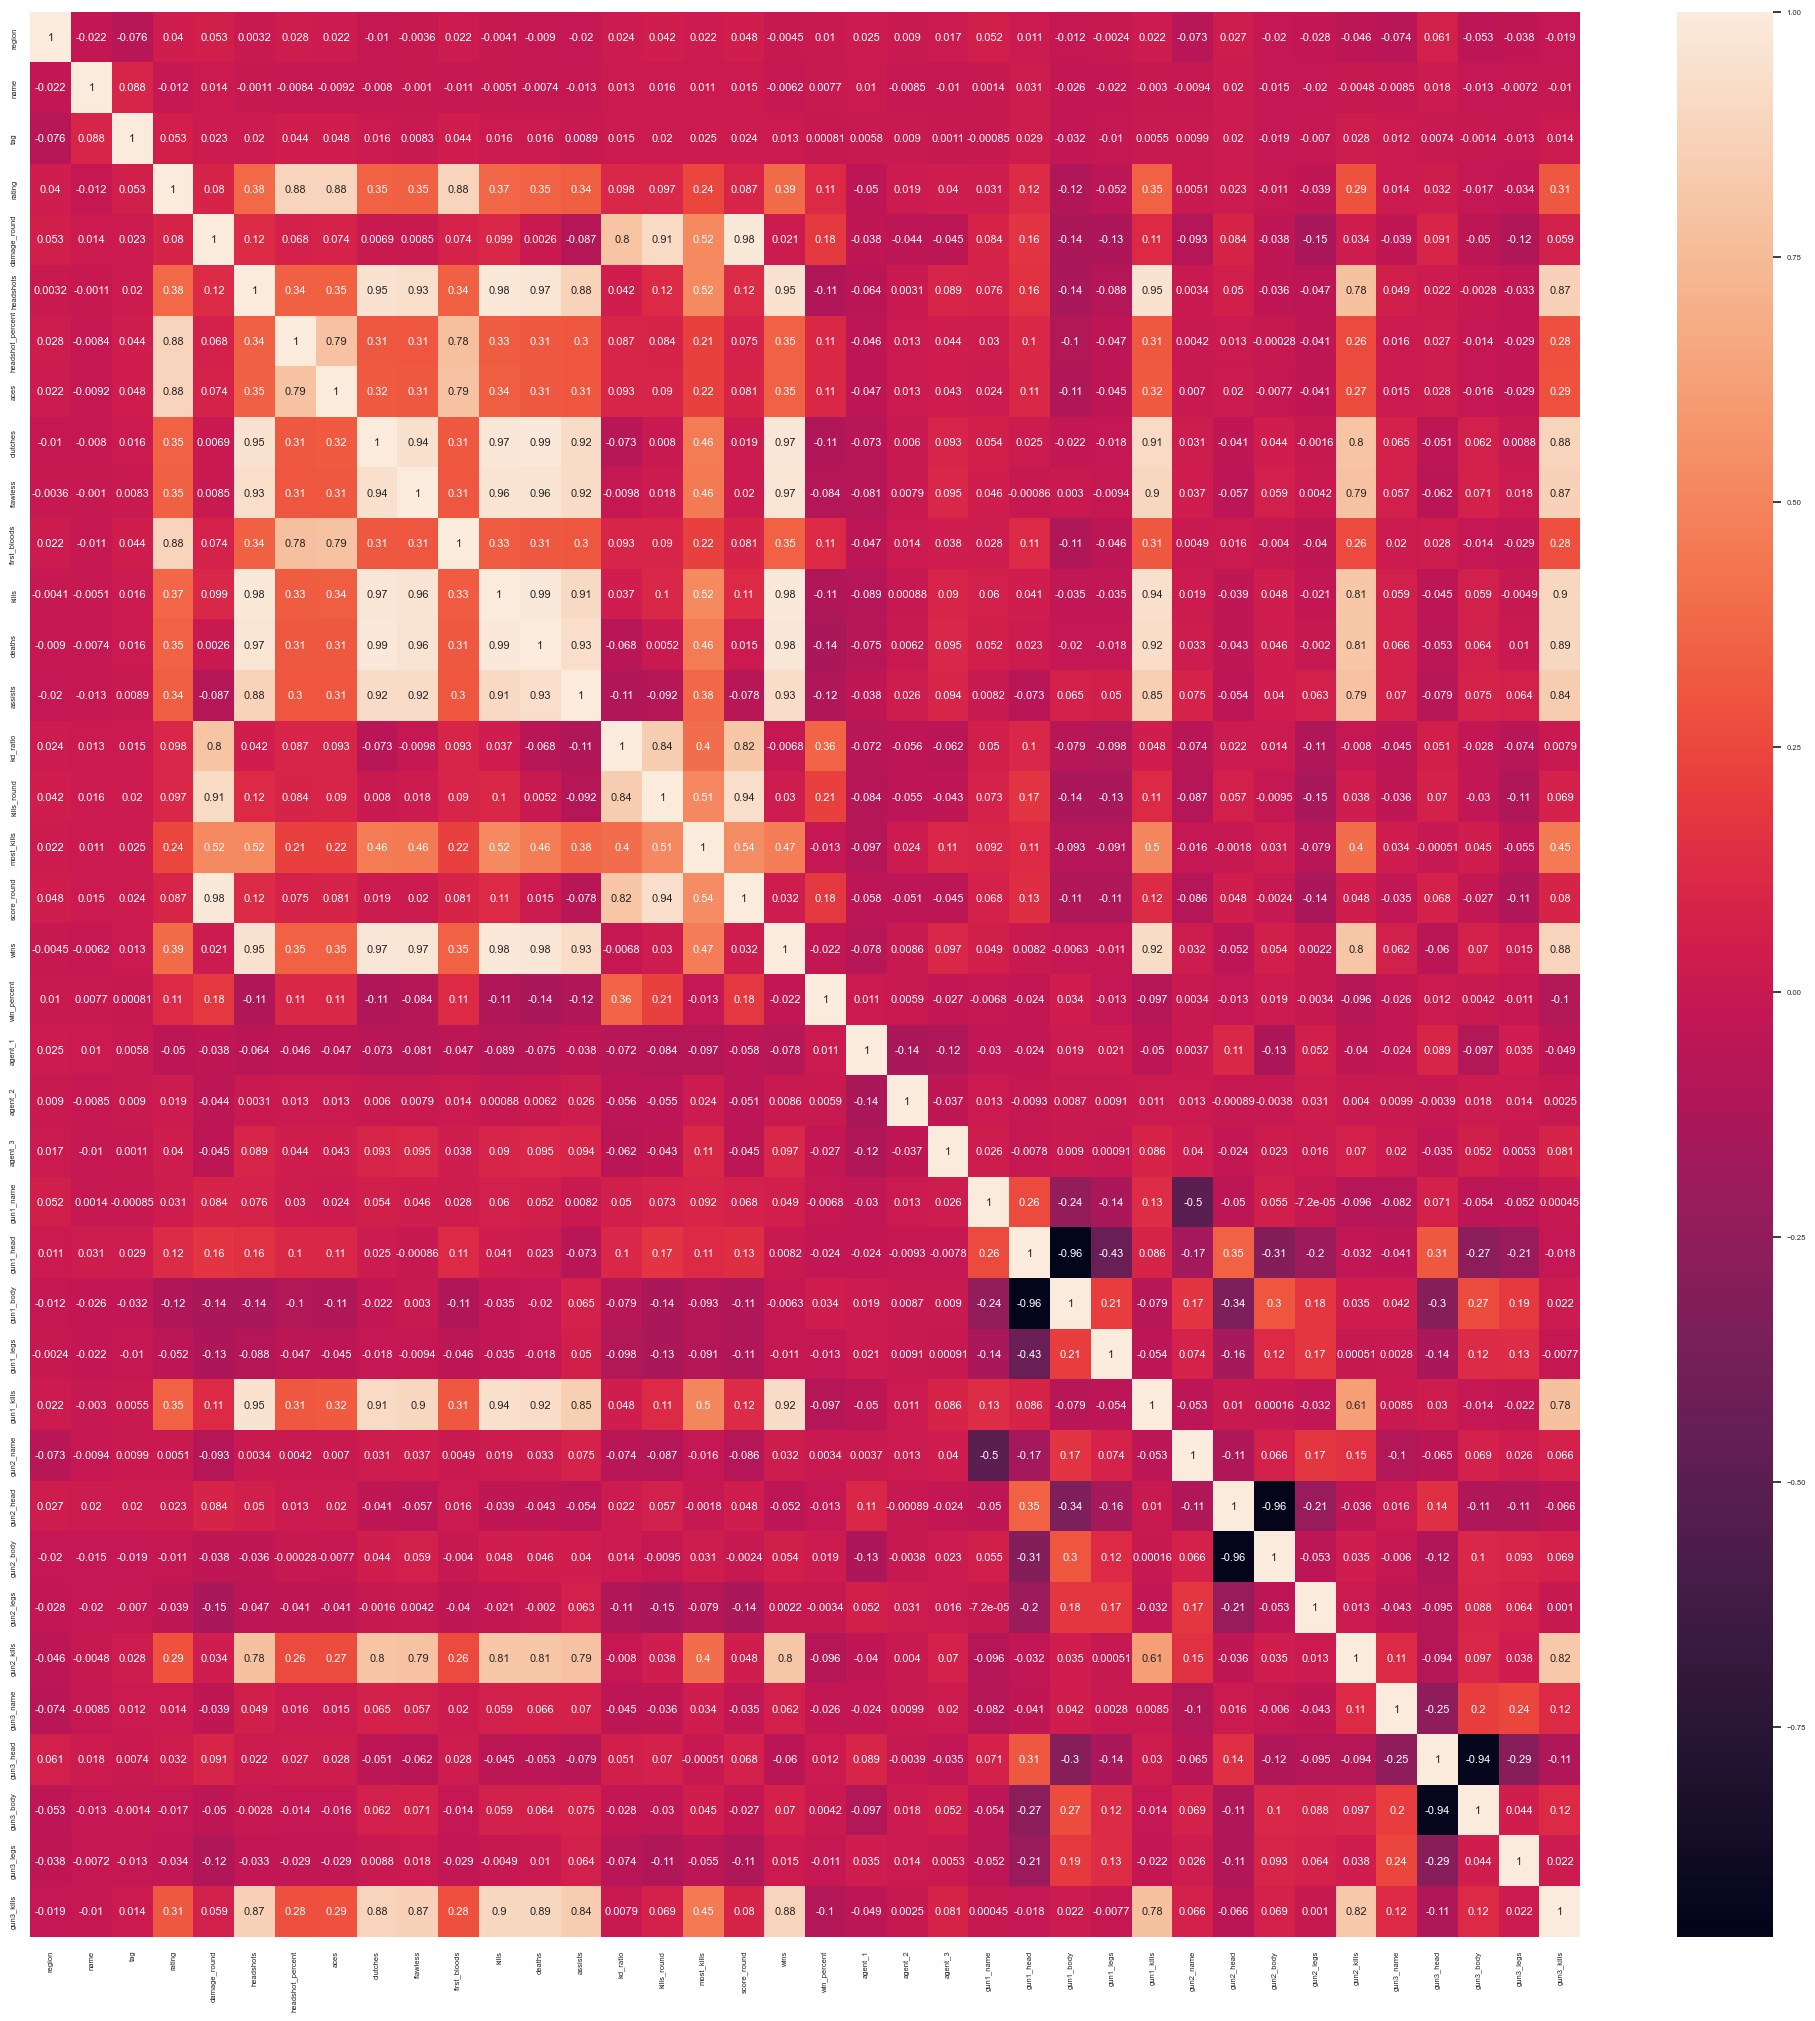

In [39]:
corrmat = sampled_dataset.corr()
# Set the font scale and style
sns.set(font_scale=0.5, style='whitegrid')

# Create a larger figure to fit the smaller text
plt.figure(figsize=(25, 25))

# Create the heatmap with annotations and decreased annotation font size
sns.heatmap(corrmat, annot=True, annot_kws={"size": 8})

# Show the plot with the adjusted font size
plt.show()

In [40]:
correlation_matrix = sampled_dataset.corr()

# Define a threshold for strong correlations
threshold = 0.95

# Find correlated variables
correlated_vars = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_vars.add((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Print correlated variable pairs
for var_pair in correlated_vars:
    print(var_pair)

('headshots', 'clutches')
('damage_round', 'score_round')
('headshots', 'deaths')
('flawless', 'kills')
('deaths', 'wins')
('gun1_head', 'gun1_body')
('clutches', 'kills')
('clutches', 'wins')
('flawless', 'wins')
('kills', 'wins')
('gun2_head', 'gun2_body')
('clutches', 'deaths')
('flawless', 'deaths')
('kills', 'deaths')
('headshots', 'kills')
('headshots', 'wins')


Based on the **correlation matrix** and **Variance Inflation Factor (VIF)** analysis, it is evident that certain predictor variables in our dataset exhibit a degree of dependence on one another. This interdependence among predictors can potentially affect the performance of certain statistical models that presume feature independence, such as linear regression. However, AutoML frameworks are equipped to handle a level of multicollinearity and still produce robust models.

To mitigate any potential issues and enhance model interpretability, we proactively identified and removed predictors that demonstrated substantial multicollinearity. The AutoML process was then re-run with this refined set of features.

The following pairs of predictors were identified as being notably correlated:

- Kills and wins, where the number of kills seems to be a strong predictor of the number of wins.
- Flawless victories and wins, suggesting that flawless performance is often associated with winning outcomes.
- Deaths and wins, indicating a possible inverse relationship where fewer deaths might lead to more wins.
- Clutches and deaths, which may reflect the critical moments in gameplay where survival impacts the game's outcome.
- Headshots and clutches, as well as headshots and deaths, point to a relationship between precision and critical gameplay moments.
- Clutches with both kills and wins, emphasizing the importance of pivotal plays in achieving victory.
- Gun-specific statistics such as gun2_head and gun2_body, gun1_head and gun1_body, which are inherently related by nature of the gameplay mechanics.
- Kills and deaths, damage_round and score_round, and flawless performance with both deaths and kills, all showcase relationships that are intuitive in the context of the game's dynamics.

The removal of these correlated predictors and the subsequent execution of AutoML with a streamlined set of features allow us to focus on the most significant variables. Importantly, the top-performing variables identified by AutoML are largely independent, reinforcing the validity of our model's insights.

## In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

From feature Importance (varimp plot) we can say that first_bloods, headshot_precent, aces are the most significant predictor.

Lets exclude all other features and only keep these from our model

In [41]:
hf.columns

['region',
 'name',
 'tag',
 'rating',
 'damage_round',
 'headshots',
 'headshot_percent',
 'aces',
 'clutches',
 'flawless',
 'first_bloods',
 'kills',
 'deaths',
 'assists',
 'kd_ratio',
 'kills_round',
 'most_kills',
 'score_round',
 'wins',
 'win_percent',
 'agent_1',
 'agent_2',
 'agent_3',
 'gun1_name',
 'gun1_head',
 'gun1_body',
 'gun1_legs',
 'gun1_kills',
 'gun2_name',
 'gun2_head',
 'gun2_body',
 'gun2_legs',
 'gun2_kills',
 'gun3_name',
 'gun3_head',
 'gun3_body',
 'gun3_legs',
 'gun3_kills']

In [42]:
features_to_drop = ['region',
 'name',
 'tag',
 'damage_round',
 'headshots',
 'clutches',
 'flawless',
 'kills',
 'deaths',
 'assists',
 'kd_ratio',
 'kills_round',
 'most_kills',
 'score_round',
 'wins',
 'win_percent',
 'agent_1',
 'agent_2',
 'agent_3',
 'gun1_name',
 'gun1_head',
 'gun1_body',
 'gun1_legs',
 'gun1_kills',
 'gun2_name',
 'gun2_head',
 'gun2_body',
 'gun2_legs',
 'gun2_kills',
 'gun3_name',
 'gun3_head',
 'gun3_body',
 'gun3_legs',
 'gun3_kills']

# Drop these features from the H2OFrame
hf_significant = hf.drop(features_to_drop)

In [43]:
target = 'rating' 

features = hf_significant.columns
features.remove(target)

aml_sig = H2OAutoML(max_runtime_secs=300, seed=1)  

aml_sig.train(x=features, y=target, training_frame=hf_significant)

AutoML progress: |
17:55:19.768: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: XRT_1_AutoML_3_20240219_175519


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    14                 154                         94480                  1            20           8.28571       2             273           44.2468

ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.019682224296443687
RMSE: 0.1402933508632668
LogLoss: 0.11667401460442295
Mean Per-Class Error: 0.5991790284099184
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Diamond 1    Diamond 3    Gold 2    Gold 3    Immortal 1    Immortal 2    Immortal 3    Platinum 1    Radiant    Silver 3    Unrated    Error      Rate
-----------  -----------  --------  --------  ------------  ------------  ------------  ------------  ---------  ----------  ---------  ---------  ------------
0            0            0         0         0             1             0             0             0          0           0          1          1 / 1
0            4            1         0         0             0             0             2             0          0           0          0.428571   3 / 7
0            1            0         0         0             0             0             0             0          0           0          1          1 / 1
0            1            0         0         0             0             0             1             0          0           0          1          2 / 2
0            0            0         1         10216         43            0             0             0          0           0          0.0042885  44 / 10,260
0            0            0         0         37            4029          103           0             1          0           0          0.0338129  141 / 4,170
0            0            0         0         1             202           1919          0             10         0           0          0.0999062  213 / 2,132
0            1            1         0         0             0             1             0             0          0           0          1          3 / 3
0            0            0         0         0             0             13            0             520        0           0          0.0243902  13 / 533
0            0            0         0         0             0             0             1             0          0           0          1          1 / 1
0            1            0         0         0             0             0             0             0          0           0          1          1 / 1
0            8            2         1         10254         4275          2036          4             531        0           0          0.0247209  423 / 17,111

Top-10 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.975279
2    0.99813
3    0.998597
4    0.998831
5    0.99889
6    0.998948
7    0.998948
8    0.998948
9    0.998948
10   0.998948

ModelMetricsMultinomial: drf
** Reported on cross-validation data. **

MSE: 0.01809052346853706
RMSE: 0.13450101660781996
LogLoss: 0.07744015989561942
Mean Per-Class Error: 0.5860348094856779
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was 

In [44]:
# Get the top model
top_model = aml_sig.leader

# Print a summary of the top model
print(top_model.summary())

# For more detailed performance metrics, you can use the model_performance() method
performance = top_model.model_performance()

# Print out the performance metrics
print(performance)

Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    14                 154                         94480                  1            20           8.28571       2             273           44.2468
ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.019682224296443687
RMSE: 0.1402933508632668
LogLoss: 0.11667401460442295
Mean Per-Class Error: 0.5991790284099184
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion 

The initial model summary showcases a GBM with good performance metrics, as evidenced by a lower MSE of 0.0070 and RMSE of 0.0839, suggesting a tight fit to the training data. The Mean Per-Class Error is notably low at 0.0952, indicating accuracy across classes.

Post feature reduction, the DRF model exhibits higher error metrics, with MSE increasing to 0.0204 and RMSE to 0.1429, reflecting reduced accuracy. The Mean Per-Class Error also rises significantly to 0.5991, pointing to decreased predictive consistency across classes.

In essence, the feature reduction appears to have diminished the model's ability to accurately predict outcomes, as crucial information may have been lost when correlated predictors were removed.

## Does the model make sense?

Yes, From our analysis GBM is the best model, modeling is done after removing the highly multi-correlated predictor has the best metrics

the GBM model emerges as the optimal model post-elimination of highly multicollinear predictors. It exhibits outstanding training performance, reflected by the following metrics:

MSE: 0.0006279336945766971
RMSE: 0.025058605200144263
LogLoss: 0.0058496757685480285
Mean Per-Class Error: 0.0

## Does regularization help?

In [45]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator


# Assuming 'hf_reduced' is your H2OFrame with the dataset already loaded into H2O
predictors = hf_reduced.columns
predictors.remove('rating')
response = 'rating' # target variable

# Initialize the GBM model with regularization parameters
gbm_model_with_regularization = H2OGradientBoostingEstimator(
    ntrees=100,
    learn_rate=0.1,
    max_depth=5,
    sample_rate=0.8,
    col_sample_rate_per_tree=0.8,
    nfolds=5,
    fold_assignment="Modulo",
    keep_cross_validation_predictions=True,
    seed=1234
)

# Train the GBM model using cross-validation
gbm_model_with_regularization.train(x=predictors, y=response, training_frame=hf_reduced)



gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1708382240077_33


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                1100                        347114                 1            5            4.97636       2             32            19.7964

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0009280662117440969
RMSE: 0.030464179157563016
LogLoss: 0.006885320048865893
Mean Per-Class Error: 0.00012756186750574028
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Diamond 1    Diamond 3    Gold 2    Gold 3    Immortal 1    Immortal 2    Immortal 3    Platinum 1    Radiant    Silver 3    Unrated    Error       Rate
-----------  -----------  --------  --------  ------------  ------------  ------------  ------------  ---------  ----------  ---------  ----------  ----------
1            0            0         0         0             0             0             0             0          0           0          0           0 / 1
0            7            0         0         0             0             0             0             0          0           0          0           0 / 7
0            0            1         0         0             0             0             0             0          0           0          0           0 / 1
0            0            0         2         0             0             0             0             0          0           0          0           0 / 2
0            0            0         0         10272         0             0             0             0          0           0          0           0 / 10,272
0            0            0         0         0             4176          0             0             0          0           0          0           0 / 4,176
0            0            0         0         0             3             2135          0             0          0           0          0.00140318  3 / 2,138
0            0            0         0         0             0             0             3             0          0           0          0           0 / 3
0            0            0         0         0             0             0             0             534        0           0          0           0 / 534
0            0            0         0         0             0             0             0             0          1           0          0           0 / 1
0            0            0         0         0             0             0             0             0          0           1          0           0 / 1
1            7            1         2         10272         4179          2135          3             534        1           1          0.00017507  3 / 17,136

Top-10 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.999825
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
10   1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.014035510216891919
RMSE: 0.1184715586834744
LogLoss: 0.05597866068626825
Mean Per-Class Error: 0.4887788941579695
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size ex

The application of regularization techniques in the Gradient Boosting Machine (GBM) model aimed to improve its generalization ability by reducing overfitting. Regularization was implemented by adjusting the `sample_rate` and `col_sample_rate_per_tree`, simulating the effects of Ridge (L2) and Lasso (L1) regularization, respectively. These adjustments influence the model by controlling the fraction of data and features used for building each tree, encouraging the model to focus on the most relevant patterns and potentially reducing the impact of noise.

**Before Regularization:**
- **Cross-Validation Data Metrics:**
  - MSE: 0.014256829641964364
  - RMSE: 0.11940196665869605
  - LogLoss: 0.055769949393464566
  - Mean Per-Class Error: 0.47567316568112666

**After Regularization:**
- **Cross-Validation Data Metrics:**
  - MSE: 0.014035510216891919 (Slightly Lower)
  - RMSE: 0.1184715586834744 (Slightly Lower)
  - LogLoss: 0.05597866068626825 (Slightly Higher)
  - Mean Per-Class Error: 0.4887788941579695 (Slightly Higher)

**Analysis:**
After applying regularization, the MSE and RMSE on the cross-validation data show a slight improvement, indicating a marginal increase in the model's prediction accuracy. However, the LogLoss has slightly increased, and the Mean Per-Class Error has also risen, suggesting that the model's average error across all classes has increased. These mixed results imply that while regularization helped in slightly improving the model's fit to the data, it may have also introduced a slight increase in classification error for some classes.

Regularization is used to prevent the model from fitting too closely to the training data, which can lead to overfitting and poor performance on unseen data. In this case, the regularization parameters (`sample_rate` and `col_sample_rate_per_tree`) were intended to make the model more robust by reducing the complexity of the trees and ensuring they do not rely too heavily on any single feature or small set of features.

**Conclusion:**
The effect of regularization on the GBM model shows the delicate balance between reducing overfitting and maintaining classification accuracy across all classes. The slight improvements in MSE and RMSE indicate a positive direction, but the increase in LogLoss and Mean Per-Class Error calls for a more nuanced approach to regularization parameter tuning. It suggests that further experimentation with these parameters, possibly alongside other model hyperparameters, could help in finding a more optimal balance that maximizes model performance while minimizing overfitting.

## Which independent variables are significant?

From the variable importance plot from an H2O Gradient Boosting Machine model shows the relative importance of predictor variables in the model. Based on the plot:

The most significant independent variables, meaning those that have the most substantial impact on the model's predictions, are as follows:

- `first_bloods`
- `headshot_percent`
- `aces`

These variables stand out with the highest importance scores, indicating that they are key drivers of the model's predictions. Variables such as `agent_3`, `agent_2`, and `kills` also appear on the plot but with less importance compared to the top variables.

In summary, the variables `first_bloods`, `headshot_percent`, and `aces` are the most significant independent variables in the model according to the variable importance plot.

## Which hyperparameters are important?

In [46]:
top_model = aml.leader
model_id = top_model.model_id
model_details = h2o.get_model(model_id)

# Print the hyperparameters of the model
print(model_details.params)


{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_1_AutoML_1_20240219_173740', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_1_AutoML_1_20240219_173740'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20240219_173740_training_Key_Frame__upload_9b28a3e8226c07d9b43c413797c94851.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20240219_173740_training_Key_Frame__upload_9b28a3e8226c07d9b43c413797c94851.hex'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20240219_173740_training_Key_Frame__upload_9b28a3e8226c07d9b43c413797c94851.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20240219_173740_training_Key_Frame__upload_9b28a3e8226c07d9b43c413797c94851.hex'}}, 'validation_frame': {'default':

The output lists various hyperparameters used by an H2O Gradient Boosting Machine model along with their default, actual, and input values. To identify the most important hyperparameters and potential areas for improvement, we can look at:

1. **Deviation from Defaults**: Hyperparameters where the actual values differ significantly from the defaults may have been chosen by the AutoML process as influential for model performance.

2. **User Input**: Hyperparameters where the input values differ from the defaults suggest deliberate tuning, indicating these parameters may be crucial to model outcomes.

From the provided output, several hyperparameters stand out:

- `ntrees`: The number of trees used is 55, higher than the default of 50, and less than the input of 10,000. This suggests the model stopped building trees well before reaching the input maximum, likely due to early stopping criteria.

- `max_depth`: The maximum depth of each tree is 8, higher than the default of 5, which allows the model to capture more complex patterns.

- `sample_rate` and `col_sample_rate`: Both are set at 0.8 instead of the default 1.0, indicating that each tree is built on 80% of the data and features. This helps in preventing overfitting.

- `stopping_metric` and `stopping_tolerance`: These are set to 'logloss' and approximately 0.0076, respectively, indicating that the model's training stopped when the log loss did not improve by this tolerance.

To potentially improve the model, you could consider adjusting these hyperparameters:

- `ntrees`: Increase if the model is underfitting or decrease if overfitting.

- `max_depth`: Decrease if the model is overfitting; increase to capture more complex relationships if underfitting.

- `sample_rate` and `col_sample_rate`: Adjust to see if a different proportion of data/features per tree improves the model.

- `stopping_tolerance`: A smaller value may lead to more extended training and potentially better performance, at the cost of longer training time.

To change and test the hyperparameters, you can manually specify them in the H2OAutoML or H2O GBM settings when initializing the model. lets adjust `max_depth` and `ntrees`:

In [47]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# Specify the hyperparameters
gbm_params = {
    'ntrees': 100,  # Increase the number of trees
    'max_depth': 6,  # Slightly decrease the tree depth
    'sample_rate': 0.8,
    'col_sample_rate': 0.8,
    'stopping_metric': 'logloss',
    'stopping_tolerance': 0.001,  # Smaller stopping tolerance
    'seed': 6  # Keep the seed for reproducibility
}

# Initialize and train the GBM model with specified hyperparameters
gbm_model = H2OGradientBoostingEstimator(**gbm_params)
gbm_model.train(y=target, training_frame=hf_reduced)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1708382240077_34


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                1100                        527812                 1            6            5.97          2             63            32.7873

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0001368164284168679
RMSE: 0.011696855492689815
LogLoss: 0.0024950665531210873
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Diamond 1    Diamond 3    Gold 2    Gold 3    Immortal 1    Immortal 2    Immortal 3    Platinum 1    Radiant    Silver 3    Unrated    Error    Rate
-----------  -----------  --------  --------  ------------  ------------  ------------  ------------  ---------  ----------  ---------  -------  ----------
1            0            0         0         0             0             0             0             0          0           0          0        0 / 1
0            7            0         0         0             0             0             0             0          0           0          0        0 / 7
0            0            1         0         0             0             0             0             0          0           0          0        0 / 1
0            0            0         2         0             0             0             0             0          0           0          0        0 / 2
0            0            0         0         10272         0             0             0             0          0           0          0        0 / 10,272
0            0            0         0         0             4176          0             0             0          0           0          0        0 / 4,176
0            0            0         0         0             0             2138          0             0          0           0          0        0 / 2,138
0            0            0         0         0             0             0             3             0          0           0          0        0 / 3
0            0            0         0         0             0             0             0             534        0           0          0        0 / 534
0            0            0         0         0             0             0             0             0          1           0          0        0 / 1
0            0            0         0         0             0             0             0             0          0           1          0        0 / 1
1            7            1         2         10272         4176          2138          3             534        1           1          0        0 / 17,136

Top-10 Hit Ratios: 
k    hit_ratio
---  -----------
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
10   1

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse         training_logloss       training_classification_error    training_auc    training_pr_auc
---  -------------------  ----------  -----------------  --------------------  ---------------------  -------------------------------  --------------  -----------------
     2024-02-19 18:00:49  0.000 sec   0.0                0.9090909090909102    2.397895272798423      0.5703781512605042               nan             nan
     2024-02-19 18:00:50  0.047 sec   1.0

After adjusting the hyperparameters, the model's performance on the training data has improved significantly:

**Before Hyperparameter Adjustment:**
- MSE: 0.0006279336945766971
- RMSE: 0.025058605200144263
- LogLoss: 0.0058496757685480285

**After Hyperparameter Adjustment:**
- MSE: 0.0001368164284168679 (approximately 4.6 times lower)
- RMSE: 0.011696855492689815 (over 2 times lower)
- LogLoss: 0.0024950665531210873 (more than 2 times lower)

The Mean Per-Class Error remains at 0.0 for both models, indicating perfect classification accuracy on the training data in both cases.

The reduction in MSE, RMSE, and LogLoss suggests that the model is fitting the training data even better after hyperparameter tuning and is likely capturing the underlying patterns more effectively. However, it's essential to validate these results on a hold-out set or through cross-validation to ensure that the model has not overfitted to the training data and can generalize well to unseen data.

References:

1. Jain, A. (2024, January 11). Ridge and lasso regression in Python | Complete tutorial (Updated 2024). Analytics Vidhya. https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/ 

2. H2O AutoML: Automatic Machine Learning — H2O 3.44.0.3 documentation. (n.d.). https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

3. Team, I. (2023, October 1). Variance Inflation Factor (VIF). Investopedia. https://www.investopedia.com/terms/v/variance-inflation-factor.asp

4. Aiskunks. (n.d.). YouTube/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Wine_Quality.ipynb at main · aiskunks/YouTube. GitHub. https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Wine_Quality.ipynb

Licences:
    
1. impyute 3.7 by Elton Law https://impyute.readthedocs.io/en/master/user_guide/getting_started.html#versions
    
2. Pandas 1.4 https://pandas.pydata.org/docs/getting_started/overview.html
    
3. Scipy.stats https://docs.scipy.org/doc/scipy/reference/stats.html
    
4. sklearn.simpleimputer https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
    
5. sklearn.LinearRegression, GridSearch https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    
6. Valorant Leaderboard Statistics https://www.kaggle.com/datasets/aliibrahim10/valorant-stats

    

MIT License

Copyright (c) 2024 MukulSaiPendem

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.